# Integrating a Keras model into a Nengo network

Often we may want to define one part of our model in Nengo, and another part in TensorFlow.  For example, suppose we are building a biological reinforcement learning model, but we'd like the inputs to our model to be natural images rather than artificial vectors.  We could load a vision network from TensorFlow, insert it into our model using NengoDL, and then build the rest of our model using normal Nengo syntax.

NengoDL supports this through the [TensorNode](https://www.nengo.ai/nengo-dl/tensor_node.html) class.  This allows us to write code directly in TensorFlow, and then insert it easily into Nengo.  In this example we will demonstrate how to integrate a Keras network into a Nengo model in a series of stages. First, inserting an entire Keras model, second, inserting individual Keras layers, and third, using native Nengo objects.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nengo
import nengo_dl

# keras uses the global random seeds, so we set those here to
# ensure the example is reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

**Introduction to TensorNodes**

`nengo_dl.TensorNode` works very similarly to `nengo.Node`, except instead of using the node to insert Python code into our model we will use it to insert TensorFlow code.  

The first thing we need to do is define our TensorNode output.  This is a function that accepts the current simulation time (and, optionally, a batch of vectors) as input, and produces a batch of vectors as output.  All of these variables will be represented as `tf.Tensor` objects, and the internal operations of the TensorNode will be implemented with TensorFlow operations. For example, we could use a TensorNode to output a `sin` function:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

| #                           Simulating                              | 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

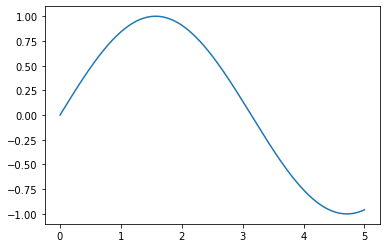

In [2]:
with nengo.Network() as net:
    def sin_func(t):
        # compute sin wave (based on simulation time)
        output = tf.sin(t)
        
        # convert output to the expected batched vector shape
        # (with batch size of 1 and vector dimensionality 1)
        output = tf.reshape(output, (1, 1))
        
        return output
    
    node = nengo_dl.TensorNode(sin_func)
    p = nengo.Probe(node)

with nengo_dl.Simulator(net) as sim:
    sim.run(5.0)
    
plt.figure()
plt.plot(sim.trange(), sim.data[p]);

However, outputting a `sin` function is something we could do more easily with a regular `nengo.Node`.  The main use case for `nengo_dl.TensorNode` is to allow us to write more complex TensorFlow code and insert it into a NengoDL model. For example, one thing we often want to do is take a deep network written in TensorFlow/Keras, and add it into a Nengo model, which is what we will focus on in this notebook.

## Inserting a whole Keras model

[Keras](https://www.tensorflow.org/guide/keras/train_and_evaluate) is a popular software package for building and training deep learning style networks.  It is a higher-level API within TensorFlow to make it easier to construct and train deep networks.  And because it is all implemented as a TensorFlow network under the hood, we can define a network using Keras and then insert it into NengoDL using a TensorNode.

This example assumes familiarity with the Keras API. Specifically it is based on the [introduction in the Tensorflow documentation](https://www.tensorflow.org/tutorials/keras/classification), so if you are not yet familiar with Keras, you may find it helpful to read those tutorials first.

In this example we'll train a neural network to classify the fashion MNIST dataset.  This dataset contains images of clothing, and the goal of the network is to identify what type of clothing it is (e.g. t-shirt, trouser, coat, etc.).

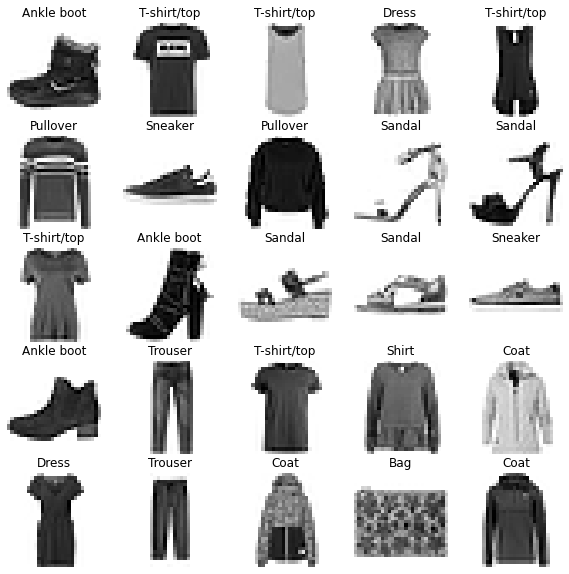

In [3]:
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.fashion_mnist.load_data())

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

Next we build and train a simple neural network, using Keras.  In this case we're building a simple two layer, densely connected network.

Note that alternatively we could define the network in Keras and then train it in NengoDL (using the `Simulator.fit` function).  But for now we'll show how to do everything in Keras.

In [4]:
inp = tf.keras.Input(train_images.shape[1:])
hidden = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(inp)
out = tf.keras.layers.Dense(units=num_classes)(hidden)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(optimizer=tf.optimizers.Adam(), 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5)

print("Test accuracy:", model.evaluate(test_images, test_labels, verbose=0)[1])

Epoch 1/5


   1/1875 [..............................] - ETA: 0s - loss: 2.2751 - accuracy: 0.0938

  37/1875 [..............................] - ETA: 2s - loss: 1.2581 - accuracy: 0.5625

  73/1875 [>.............................] - ETA: 2s - loss: 1.0259 - accuracy: 0.6370

 108/1875 [>.............................] - ETA: 2s - loss: 0.9065 - accuracy: 0.6817

 142/1875 [=>............................] - ETA: 2s - loss: 0.8407 - accuracy: 0.7038

 178/1875 [=>............................] - ETA: 2s - loss: 0.7943 - accuracy: 0.7209

 215/1875 [==>...........................] - ETA: 2s - loss: 0.7628 - accuracy: 0.7317

 248/1875 [==>...........................] - ETA: 2s - loss: 0.7352 - accuracy: 0.7427

 283/1875 [===>..........................] - ETA: 2s - loss: 0.7108 - accuracy: 0.7511

 319/1875 [====>.........................] - ETA: 2s - loss: 0.6933 - accuracy: 0.7559

 355/1875 [====>.........................] - ETA: 2s - loss: 0.6784 - accuracy: 0.7610

 387/1875 [=====>........................] - ETA: 2s - loss: 0.6723 - accuracy: 0.7635

 424/1875 [=====>........................] - ETA: 2s - loss: 0.6581 - accuracy: 0.7690

 460/1875 [======>.......................] - ETA: 2s - loss: 0.6447 - accuracy: 0.7738

 496/1875 [======>.......................] - ETA: 1s - loss: 0.6371 - accuracy: 0.7765

 530/1875 [=======>......................] - ETA: 1s - loss: 0.6287 - accuracy: 0.7795

 564/1875 [========>.....................] - ETA: 1s - loss: 0.6203 - accuracy: 0.7830

 597/1875 [========>.....................] - ETA: 1s - loss: 0.6164 - accuracy: 0.7837

 629/1875 [=========>....................] - ETA: 1s - loss: 0.6117 - accuracy: 0.7856

 663/1875 [=========>....................] - ETA: 1s - loss: 0.6047 - accuracy: 0.7887

 698/1875 [==========>...................] - ETA: 1s - loss: 0.5960 - accuracy: 0.7920

 733/1875 [==========>...................] - ETA: 1s - loss: 0.5919 - accuracy: 0.7928

 767/1875 [===========>..................] - ETA: 1s - loss: 0.5862 - accuracy: 0.7942

 802/1875 [===========>..................] - ETA: 1s - loss: 0.5810 - accuracy: 0.7956

 832/1875 [============>.................] - ETA: 1s - loss: 0.5784 - accuracy: 0.7962

 867/1875 [============>.................] - ETA: 1s - loss: 0.5754 - accuracy: 0.7975

 903/1875 [=============>................] - ETA: 1s - loss: 0.5704 - accuracy: 0.7994

 938/1875 [==============>...............] - ETA: 1s - loss: 0.5644 - accuracy: 0.8019

 973/1875 [==============>...............] - ETA: 1s - loss: 0.5609 - accuracy: 0.8031

1010/1875 [===============>..............] - ETA: 1s - loss: 0.5570 - accuracy: 0.8048

1046/1875 [===============>..............] - ETA: 1s - loss: 0.5526 - accuracy: 0.8061

1082/1875 [================>.............] - ETA: 1s - loss: 0.5487 - accuracy: 0.8075

1114/1875 [================>.............] - ETA: 1s - loss: 0.5461 - accuracy: 0.8082

1150/1875 [=================>............] - ETA: 1s - loss: 0.5427 - accuracy: 0.8096

1180/1875 [=================>............] - ETA: 1s - loss: 0.5396 - accuracy: 0.8105

1213/1875 [==================>...........] - ETA: 0s - loss: 0.5367 - accuracy: 0.8114

1250/1875 [===================>..........] - ETA: 0s - loss: 0.5337 - accuracy: 0.8125

1285/1875 [===================>..........] - ETA: 0s - loss: 0.5316 - accuracy: 0.8135

1319/1875 [====================>.........] - ETA: 0s - loss: 0.5297 - accuracy: 0.8143

1344/1875 [====================>.........] - ETA: 0s - loss: 0.5281 - accuracy: 0.8150

1374/1875 [====================>.........] - ETA: 0s - loss: 0.5253 - accuracy: 0.8158

1406/1875 [=====================>........] - ETA: 0s - loss: 0.5233 - accuracy: 0.8165

1440/1875 [======================>.......] - ETA: 0s - loss: 0.5208 - accuracy: 0.8172

1468/1875 [======================>.......] - ETA: 0s - loss: 0.5186 - accuracy: 0.8181

1501/1875 [=======================>......] - ETA: 0s - loss: 0.5157 - accuracy: 0.8191

1536/1875 [=======================>......] - ETA: 0s - loss: 0.5147 - accuracy: 0.8194

1571/1875 [========================>.....] - ETA: 0s - loss: 0.5132 - accuracy: 0.8199

1605/1875 [========================>.....] - ETA: 0s - loss: 0.5121 - accuracy: 0.8203

1639/1875 [=========================>....] - ETA: 0s - loss: 0.5098 - accuracy: 0.8208

1674/1875 [=========================>....] - ETA: 0s - loss: 0.5074 - accuracy: 0.8218

1706/1875 [==========================>...] - ETA: 0s - loss: 0.5072 - accuracy: 0.8221

1742/1875 [==========================>...] - ETA: 0s - loss: 0.5045 - accuracy: 0.8229

1776/1875 [===========================>..] - ETA: 0s - loss: 0.5022 - accuracy: 0.8237

1813/1875 [============================>.] - ETA: 0s - loss: 0.5007 - accuracy: 0.8242

1845/1875 [============================>.] - ETA: 0s - loss: 0.5000 - accuracy: 0.8247

1875/1875 [==============================] - 3s 1ms/step - loss: 0.4992 - accuracy: 0.8246


Epoch 2/5
   1/1875 [..............................] - ETA: 0s - loss: 0.1635 - accuracy: 0.9688

  30/1875 [..............................] - ETA: 3s - loss: 0.3732 - accuracy: 0.8729

  63/1875 [>.............................] - ETA: 3s - loss: 0.3730 - accuracy: 0.8735

  97/1875 [>.............................] - ETA: 2s - loss: 0.3896 - accuracy: 0.8634

 134/1875 [=>............................] - ETA: 2s - loss: 0.3934 - accuracy: 0.8619

 171/1875 [=>............................] - ETA: 2s - loss: 0.3991 - accuracy: 0.8573

 207/1875 [==>...........................] - ETA: 2s - loss: 0.3911 - accuracy: 0.8610

 236/1875 [==>...........................] - ETA: 2s - loss: 0.3897 - accuracy: 0.8615

 272/1875 [===>..........................] - ETA: 2s - loss: 0.3930 - accuracy: 0.8595

 306/1875 [===>..........................] - ETA: 2s - loss: 0.3984 - accuracy: 0.8577

 341/1875 [====>.........................] - ETA: 2s - loss: 0.3948 - accuracy: 0.8584

 377/1875 [=====>........................] - ETA: 2s - loss: 0.3901 - accuracy: 0.8595

 413/1875 [=====>........................] - ETA: 2s - loss: 0.3877 - accuracy: 0.8590

 448/1875 [======>.......................] - ETA: 2s - loss: 0.3867 - accuracy: 0.8594

 484/1875 [======>.......................] - ETA: 2s - loss: 0.3851 - accuracy: 0.8601

 516/1875 [=======>......................] - ETA: 2s - loss: 0.3880 - accuracy: 0.8592

 553/1875 [=======>......................] - ETA: 1s - loss: 0.3853 - accuracy: 0.8605

 580/1875 [========>.....................] - ETA: 1s - loss: 0.3856 - accuracy: 0.8599

 616/1875 [========>.....................] - ETA: 1s - loss: 0.3854 - accuracy: 0.8597

 652/1875 [=========>....................] - ETA: 1s - loss: 0.3868 - accuracy: 0.8590

 688/1875 [==========>...................] - ETA: 1s - loss: 0.3855 - accuracy: 0.8593

 724/1875 [==========>...................] - ETA: 1s - loss: 0.3865 - accuracy: 0.8588

 759/1875 [===========>..................] - ETA: 1s - loss: 0.3863 - accuracy: 0.8590

 795/1875 [===========>..................] - ETA: 1s - loss: 0.3869 - accuracy: 0.8590

 831/1875 [============>.................] - ETA: 1s - loss: 0.3859 - accuracy: 0.8591

 866/1875 [============>.................] - ETA: 1s - loss: 0.3835 - accuracy: 0.8610

 899/1875 [=============>................] - ETA: 1s - loss: 0.3837 - accuracy: 0.8612

 935/1875 [=============>................] - ETA: 1s - loss: 0.3828 - accuracy: 0.8614

 971/1875 [==============>...............] - ETA: 1s - loss: 0.3821 - accuracy: 0.8613

1006/1875 [===============>..............] - ETA: 1s - loss: 0.3824 - accuracy: 0.8611

1036/1875 [===============>..............] - ETA: 1s - loss: 0.3810 - accuracy: 0.8613

1069/1875 [================>.............] - ETA: 1s - loss: 0.3807 - accuracy: 0.8615

1103/1875 [================>.............] - ETA: 1s - loss: 0.3796 - accuracy: 0.8622

1135/1875 [=================>............] - ETA: 1s - loss: 0.3780 - accuracy: 0.8627

1168/1875 [=================>............] - ETA: 1s - loss: 0.3782 - accuracy: 0.8626

1204/1875 [==================>...........] - ETA: 0s - loss: 0.3784 - accuracy: 0.8628

1235/1875 [==================>...........] - ETA: 0s - loss: 0.3788 - accuracy: 0.8626

1269/1875 [===================>..........] - ETA: 0s - loss: 0.3792 - accuracy: 0.8625

1305/1875 [===================>..........] - ETA: 0s - loss: 0.3803 - accuracy: 0.8618

1340/1875 [====================>.........] - ETA: 0s - loss: 0.3811 - accuracy: 0.8617

1376/1875 [=====================>........] - ETA: 0s - loss: 0.3800 - accuracy: 0.8621

1406/1875 [=====================>........] - ETA: 0s - loss: 0.3788 - accuracy: 0.8626

1433/1875 [=====================>........] - ETA: 0s - loss: 0.3790 - accuracy: 0.8625

1469/1875 [======================>.......] - ETA: 0s - loss: 0.3793 - accuracy: 0.8627

1506/1875 [=======================>......] - ETA: 0s - loss: 0.3796 - accuracy: 0.8625

1542/1875 [=======================>......] - ETA: 0s - loss: 0.3796 - accuracy: 0.8627

1579/1875 [========================>.....] - ETA: 0s - loss: 0.3798 - accuracy: 0.8627

1614/1875 [========================>.....] - ETA: 0s - loss: 0.3792 - accuracy: 0.8630

1651/1875 [=========================>....] - ETA: 0s - loss: 0.3784 - accuracy: 0.8631

1687/1875 [=========================>....] - ETA: 0s - loss: 0.3780 - accuracy: 0.8635

1724/1875 [==========================>...] - ETA: 0s - loss: 0.3779 - accuracy: 0.8634

1760/1875 [===========================>..] - ETA: 0s - loss: 0.3777 - accuracy: 0.8635

1796/1875 [===========================>..] - ETA: 0s - loss: 0.3769 - accuracy: 0.8637

1829/1875 [============================>.] - ETA: 0s - loss: 0.3767 - accuracy: 0.8639

1864/1875 [============================>.] - ETA: 0s - loss: 0.3758 - accuracy: 0.8645

1875/1875 [==============================] - 3s 1ms/step - loss: 0.3758 - accuracy: 0.8644


Epoch 3/5
   1/1875 [..............................] - ETA: 0s - loss: 0.4776 - accuracy: 0.8438

  36/1875 [..............................] - ETA: 2s - loss: 0.3354 - accuracy: 0.8698

  68/1875 [>.............................] - ETA: 2s - loss: 0.3549 - accuracy: 0.8653

 102/1875 [>.............................] - ETA: 2s - loss: 0.3474 - accuracy: 0.8689

 137/1875 [=>............................] - ETA: 2s - loss: 0.3448 - accuracy: 0.8702

 171/1875 [=>............................] - ETA: 2s - loss: 0.3430 - accuracy: 0.8717

 205/1875 [==>...........................] - ETA: 2s - loss: 0.3383 - accuracy: 0.8748

 237/1875 [==>...........................] - ETA: 2s - loss: 0.3314 - accuracy: 0.8765

 270/1875 [===>..........................] - ETA: 2s - loss: 0.3342 - accuracy: 0.8763

 306/1875 [===>..........................] - ETA: 2s - loss: 0.3358 - accuracy: 0.8753

 339/1875 [====>.........................] - ETA: 2s - loss: 0.3344 - accuracy: 0.8759

 376/1875 [=====>........................] - ETA: 2s - loss: 0.3327 - accuracy: 0.8769

 409/1875 [=====>........................] - ETA: 2s - loss: 0.3347 - accuracy: 0.8759

 446/1875 [======>.......................] - ETA: 2s - loss: 0.3328 - accuracy: 0.8760

 483/1875 [======>.......................] - ETA: 2s - loss: 0.3360 - accuracy: 0.8756

 515/1875 [=======>......................] - ETA: 2s - loss: 0.3374 - accuracy: 0.8754

 548/1875 [=======>......................] - ETA: 1s - loss: 0.3391 - accuracy: 0.8749

 581/1875 [========>.....................] - ETA: 1s - loss: 0.3365 - accuracy: 0.8766

 616/1875 [========>.....................] - ETA: 1s - loss: 0.3369 - accuracy: 0.8760

 651/1875 [=========>....................] - ETA: 1s - loss: 0.3384 - accuracy: 0.8757

 687/1875 [=========>....................] - ETA: 1s - loss: 0.3391 - accuracy: 0.8751

 722/1875 [==========>...................] - ETA: 1s - loss: 0.3389 - accuracy: 0.8751

 754/1875 [===========>..................] - ETA: 1s - loss: 0.3401 - accuracy: 0.8742

 787/1875 [===========>..................] - ETA: 1s - loss: 0.3408 - accuracy: 0.8744

 823/1875 [============>.................] - ETA: 1s - loss: 0.3410 - accuracy: 0.8741

 856/1875 [============>.................] - ETA: 1s - loss: 0.3411 - accuracy: 0.8739

 888/1875 [=============>................] - ETA: 1s - loss: 0.3393 - accuracy: 0.8745

 922/1875 [=============>................] - ETA: 1s - loss: 0.3380 - accuracy: 0.8753

 957/1875 [==============>...............] - ETA: 1s - loss: 0.3374 - accuracy: 0.8756

 993/1875 [==============>...............] - ETA: 1s - loss: 0.3379 - accuracy: 0.8754

1028/1875 [===============>..............] - ETA: 1s - loss: 0.3378 - accuracy: 0.8756

1063/1875 [================>.............] - ETA: 1s - loss: 0.3369 - accuracy: 0.8760

1094/1875 [================>.............] - ETA: 1s - loss: 0.3375 - accuracy: 0.8758

1130/1875 [=================>............] - ETA: 1s - loss: 0.3368 - accuracy: 0.8761

1166/1875 [=================>............] - ETA: 1s - loss: 0.3372 - accuracy: 0.8759

1202/1875 [==================>...........] - ETA: 0s - loss: 0.3362 - accuracy: 0.8764

1236/1875 [==================>...........] - ETA: 0s - loss: 0.3354 - accuracy: 0.8769

1270/1875 [===================>..........] - ETA: 0s - loss: 0.3356 - accuracy: 0.8765

1304/1875 [===================>..........] - ETA: 0s - loss: 0.3346 - accuracy: 0.8766

1337/1875 [====================>.........] - ETA: 0s - loss: 0.3343 - accuracy: 0.8770

1373/1875 [====================>.........] - ETA: 0s - loss: 0.3357 - accuracy: 0.8767

1408/1875 [=====================>........] - ETA: 0s - loss: 0.3359 - accuracy: 0.8768

1444/1875 [======================>.......] - ETA: 0s - loss: 0.3360 - accuracy: 0.8768

1477/1875 [======================>.......] - ETA: 0s - loss: 0.3363 - accuracy: 0.8766

1507/1875 [=======================>......] - ETA: 0s - loss: 0.3365 - accuracy: 0.8766



1540/1875 [=======================>......] - ETA: 0s - loss: 0.3377 - accuracy: 0.8762

1574/1875 [========================>.....] - ETA: 0s - loss: 0.3381 - accuracy: 0.8760

1609/1875 [========================>.....] - ETA: 0s - loss: 0.3379 - accuracy: 0.8760

1644/1875 [=========================>....] - ETA: 0s - loss: 0.3378 - accuracy: 0.8760

1677/1875 [=========================>....] - ETA: 0s - loss: 0.3378 - accuracy: 0.8761

1710/1875 [==========================>...] - ETA: 0s - loss: 0.3375 - accuracy: 0.8759

1747/1875 [==========================>...] - ETA: 0s - loss: 0.3379 - accuracy: 0.8758

1783/1875 [===========================>..] - ETA: 0s - loss: 0.3375 - accuracy: 0.8760

1819/1875 [============================>.] - ETA: 0s - loss: 0.3371 - accuracy: 0.8762

1854/1875 [============================>.] - ETA: 0s - loss: 0.3373 - accuracy: 0.8760

1875/1875 [==============================] - 3s 1ms/step - loss: 0.3373 - accuracy: 0.8760


Epoch 4/5
   1/1875 [..............................] - ETA: 0s - loss: 0.2194 - accuracy: 0.9062

  37/1875 [..............................] - ETA: 2s - loss: 0.3348 - accuracy: 0.8682

  72/1875 [>.............................] - ETA: 2s - loss: 0.3373 - accuracy: 0.8672

 107/1875 [>.............................] - ETA: 2s - loss: 0.3225 - accuracy: 0.8785

 142/1875 [=>............................] - ETA: 2s - loss: 0.3152 - accuracy: 0.8807

 174/1875 [=>............................] - ETA: 2s - loss: 0.3114 - accuracy: 0.8827

 208/1875 [==>...........................] - ETA: 2s - loss: 0.3163 - accuracy: 0.8818

 243/1875 [==>...........................] - ETA: 2s - loss: 0.3131 - accuracy: 0.8817

 280/1875 [===>..........................] - ETA: 2s - loss: 0.3111 - accuracy: 0.8837

 314/1875 [====>.........................] - ETA: 2s - loss: 0.3124 - accuracy: 0.8846

 349/1875 [====>.........................] - ETA: 2s - loss: 0.3137 - accuracy: 0.8839

 385/1875 [=====>........................] - ETA: 2s - loss: 0.3142 - accuracy: 0.8835

 420/1875 [=====>........................] - ETA: 2s - loss: 0.3141 - accuracy: 0.8839

 452/1875 [======>.......................] - ETA: 2s - loss: 0.3112 - accuracy: 0.8854

 489/1875 [======>.......................] - ETA: 2s - loss: 0.3132 - accuracy: 0.8845

 523/1875 [=======>......................] - ETA: 1s - loss: 0.3110 - accuracy: 0.8847

 558/1875 [=======>......................] - ETA: 1s - loss: 0.3089 - accuracy: 0.8859

 592/1875 [========>.....................] - ETA: 1s - loss: 0.3090 - accuracy: 0.8859

 625/1875 [=========>....................] - ETA: 1s - loss: 0.3092 - accuracy: 0.8859

 660/1875 [=========>....................] - ETA: 1s - loss: 0.3105 - accuracy: 0.8855

 696/1875 [==========>...................] - ETA: 1s - loss: 0.3104 - accuracy: 0.8854

 733/1875 [==========>...................] - ETA: 1s - loss: 0.3103 - accuracy: 0.8856

 769/1875 [===========>..................] - ETA: 1s - loss: 0.3090 - accuracy: 0.8860

 802/1875 [===========>..................] - ETA: 1s - loss: 0.3078 - accuracy: 0.8867

 836/1875 [============>.................] - ETA: 1s - loss: 0.3061 - accuracy: 0.8879

 869/1875 [============>.................] - ETA: 1s - loss: 0.3081 - accuracy: 0.8870

 906/1875 [=============>................] - ETA: 1s - loss: 0.3070 - accuracy: 0.8874

 942/1875 [==============>...............] - ETA: 1s - loss: 0.3073 - accuracy: 0.8872

 974/1875 [==============>...............] - ETA: 1s - loss: 0.3069 - accuracy: 0.8876

1008/1875 [===============>..............] - ETA: 1s - loss: 0.3077 - accuracy: 0.8879

1044/1875 [===============>..............] - ETA: 1s - loss: 0.3082 - accuracy: 0.8879

1080/1875 [================>.............] - ETA: 1s - loss: 0.3092 - accuracy: 0.8875

1116/1875 [================>.............] - ETA: 1s - loss: 0.3083 - accuracy: 0.8878

1152/1875 [=================>............] - ETA: 1s - loss: 0.3091 - accuracy: 0.8875

1188/1875 [==================>...........] - ETA: 0s - loss: 0.3093 - accuracy: 0.8875

1224/1875 [==================>...........] - ETA: 0s - loss: 0.3093 - accuracy: 0.8872

1259/1875 [===================>..........] - ETA: 0s - loss: 0.3091 - accuracy: 0.8872

1295/1875 [===================>..........] - ETA: 0s - loss: 0.3089 - accuracy: 0.8872

1328/1875 [====================>.........] - ETA: 0s - loss: 0.3089 - accuracy: 0.8871

1364/1875 [====================>.........] - ETA: 0s - loss: 0.3089 - accuracy: 0.8871

1395/1875 [=====================>........] - ETA: 0s - loss: 0.3091 - accuracy: 0.8871

1430/1875 [=====================>........] - ETA: 0s - loss: 0.3092 - accuracy: 0.8871

1465/1875 [======================>.......] - ETA: 0s - loss: 0.3096 - accuracy: 0.8866

1497/1875 [======================>.......] - ETA: 0s - loss: 0.3096 - accuracy: 0.8865

1530/1875 [=======================>......] - ETA: 0s - loss: 0.3096 - accuracy: 0.8862

1566/1875 [========================>.....] - ETA: 0s - loss: 0.3098 - accuracy: 0.8862

1601/1875 [========================>.....] - ETA: 0s - loss: 0.3103 - accuracy: 0.8860

1636/1875 [=========================>....] - ETA: 0s - loss: 0.3105 - accuracy: 0.8859

1671/1875 [=========================>....] - ETA: 0s - loss: 0.3097 - accuracy: 0.8862

1707/1875 [==========================>...] - ETA: 0s - loss: 0.3093 - accuracy: 0.8863

1743/1875 [==========================>...] - ETA: 0s - loss: 0.3088 - accuracy: 0.8865

1779/1875 [===========================>..] - ETA: 0s - loss: 0.3094 - accuracy: 0.8864

1810/1875 [===========================>..] - ETA: 0s - loss: 0.3108 - accuracy: 0.8858

1845/1875 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.8857

1875/1875 [==============================] - 3s 1ms/step - loss: 0.3113 - accuracy: 0.8856


Epoch 5/5
   1/1875 [..............................] - ETA: 0s - loss: 0.2200 - accuracy: 0.9375

  37/1875 [..............................] - ETA: 2s - loss: 0.3050 - accuracy: 0.8809

  72/1875 [>.............................] - ETA: 2s - loss: 0.2731 - accuracy: 0.8932

 107/1875 [>.............................] - ETA: 2s - loss: 0.2657 - accuracy: 0.8978

 140/1875 [=>............................] - ETA: 2s - loss: 0.2680 - accuracy: 0.8946

 176/1875 [=>............................] - ETA: 2s - loss: 0.2758 - accuracy: 0.8944

 210/1875 [==>...........................] - ETA: 2s - loss: 0.2802 - accuracy: 0.8939

 245/1875 [==>...........................] - ETA: 2s - loss: 0.2843 - accuracy: 0.8938

 282/1875 [===>..........................] - ETA: 2s - loss: 0.2852 - accuracy: 0.8936

 318/1875 [====>.........................] - ETA: 2s - loss: 0.2870 - accuracy: 0.8936

 353/1875 [====>.........................] - ETA: 2s - loss: 0.2873 - accuracy: 0.8933

 389/1875 [=====>........................] - ETA: 2s - loss: 0.2864 - accuracy: 0.8947

 426/1875 [=====>........................] - ETA: 2s - loss: 0.2874 - accuracy: 0.8943

 462/1875 [======>.......................] - ETA: 2s - loss: 0.2865 - accuracy: 0.8943

 498/1875 [======>.......................] - ETA: 1s - loss: 0.2849 - accuracy: 0.8956

 535/1875 [=======>......................] - ETA: 1s - loss: 0.2863 - accuracy: 0.8954

 571/1875 [========>.....................] - ETA: 1s - loss: 0.2894 - accuracy: 0.8944

 606/1875 [========>.....................] - ETA: 1s - loss: 0.2904 - accuracy: 0.8944

 641/1875 [=========>....................] - ETA: 1s - loss: 0.2932 - accuracy: 0.8929

 676/1875 [=========>....................] - ETA: 1s - loss: 0.2932 - accuracy: 0.8928

 712/1875 [==========>...................] - ETA: 1s - loss: 0.2922 - accuracy: 0.8933

 748/1875 [==========>...................] - ETA: 1s - loss: 0.2933 - accuracy: 0.8930

 784/1875 [===========>..................] - ETA: 1s - loss: 0.2943 - accuracy: 0.8924

 821/1875 [============>.................] - ETA: 1s - loss: 0.2927 - accuracy: 0.8929

 855/1875 [============>.................] - ETA: 1s - loss: 0.2925 - accuracy: 0.8925

 886/1875 [=============>................] - ETA: 1s - loss: 0.2924 - accuracy: 0.8924

 922/1875 [=============>................] - ETA: 1s - loss: 0.2932 - accuracy: 0.8922

 958/1875 [==============>...............] - ETA: 1s - loss: 0.2940 - accuracy: 0.8918

 994/1875 [==============>...............] - ETA: 1s - loss: 0.2938 - accuracy: 0.8917

1023/1875 [===============>..............] - ETA: 1s - loss: 0.2931 - accuracy: 0.8918

1051/1875 [===============>..............] - ETA: 1s - loss: 0.2915 - accuracy: 0.8925

1086/1875 [================>.............] - ETA: 1s - loss: 0.2913 - accuracy: 0.8926

1121/1875 [================>.............] - ETA: 1s - loss: 0.2913 - accuracy: 0.8926

1157/1875 [=================>............] - ETA: 1s - loss: 0.2904 - accuracy: 0.8931

1193/1875 [==================>...........] - ETA: 0s - loss: 0.2894 - accuracy: 0.8934

1226/1875 [==================>...........] - ETA: 0s - loss: 0.2909 - accuracy: 0.8929

1262/1875 [===================>..........] - ETA: 0s - loss: 0.2913 - accuracy: 0.8926

1298/1875 [===================>..........] - ETA: 0s - loss: 0.2909 - accuracy: 0.8928

1334/1875 [====================>.........] - ETA: 0s - loss: 0.2909 - accuracy: 0.8926

1369/1875 [====================>.........] - ETA: 0s - loss: 0.2911 - accuracy: 0.8926

1404/1875 [=====================>........] - ETA: 0s - loss: 0.2920 - accuracy: 0.8922

1440/1875 [======================>.......] - ETA: 0s - loss: 0.2925 - accuracy: 0.8920

1477/1875 [======================>.......] - ETA: 0s - loss: 0.2936 - accuracy: 0.8917

1512/1875 [=======================>......] - ETA: 0s - loss: 0.2949 - accuracy: 0.8911

1548/1875 [=======================>......] - ETA: 0s - loss: 0.2942 - accuracy: 0.8912

1585/1875 [========================>.....] - ETA: 0s - loss: 0.2938 - accuracy: 0.8914

1622/1875 [========================>.....] - ETA: 0s - loss: 0.2937 - accuracy: 0.8915

1657/1875 [=========================>....] - ETA: 0s - loss: 0.2933 - accuracy: 0.8917

1692/1875 [==========================>...] - ETA: 0s - loss: 0.2937 - accuracy: 0.8915

1726/1875 [==========================>...] - ETA: 0s - loss: 0.2941 - accuracy: 0.8914

1740/1875 [==========================>...] - ETA: 0s - loss: 0.2939 - accuracy: 0.8914

1773/1875 [===========================>..] - ETA: 0s - loss: 0.2938 - accuracy: 0.8914

1797/1875 [===========================>..] - ETA: 0s - loss: 0.2934 - accuracy: 0.8918

1833/1875 [============================>.] - ETA: 0s - loss: 0.2930 - accuracy: 0.8920

1868/1875 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.8918

1875/1875 [==============================] - 3s 1ms/step - loss: 0.2935 - accuracy: 0.8917


Test accuracy: 0.8727999925613403


We'll save the trained weights, so that we can load them later within our TensorNode.

In [5]:
model_weights = "keras_weights"
model.save_weights(model_weights)

Now we're ready to create our TensorNode.  Our TensorNode needs to be a bit more complicated in this case, since we need to load in the model from above and the pretrained weights.  We can accomplish this by creating a custom Keras Layer, which allows us to define `build` and `call` methods.

We'll use the `build` function to call the Keras `clone_model` function.  This effectively reruns the Keras model definition from above, but because we're calling it within the `build` stage it will be naturally integrated into the NengoDL model that is being built.

The `call` function is where we do the main job of constructing the TensorFlow elements that will implement our node.  It will take TensorFlow Tensors as input and produce a `tf.Tensor` as output, as with the `tf.sin` example above.  In this case we apply the Keras model to the TensorNode inputs.  This adds the TensorFlow elements that implement that Keras model into the simulation graph.

In [6]:
class KerasWrapper(tf.keras.layers.Layer):
    def __init__(self, keras_model):
        super().__init__()
        
        self.model = keras_model
        
    def build(self, input_shapes):
        super().build(input_shapes)
        
        # we use clone_model to re-build the model
        # within the TensorNode context
        self.model = tf.keras.models.clone_model(self.model)
        
        # load the weights we saved above
        self.model.load_weights(model_weights)
        
    def call(self, inputs):
        # apply the model to the inputs
        return self.model(inputs)

Now that we have our `KerasWrapper` class, we can use it to insert our Keras model into a Nengo network via a `TensorNode`. We simply instantiate a `KerasWrapper` (passing in our Keras model from above), and then pass that Layer object to the `TensorNode`.

In [7]:
with nengo.Network() as net:
    # create a normal input node to feed in our test image.
    # the `np.ones` array is a placeholder, these
    # values will be replaced with the Fashion MNIST images
    # when we run the Simulator.
    input_node = nengo.Node(output=np.ones(28 * 28))

    # create an instance of the custom layer class we created,
    # passing it the Keras model
    layer = KerasWrapper(model)
    
    # create a TensorNode and pass it the new layer
    keras_node = nengo_dl.TensorNode(
        layer,
        shape_in=(28*28,),  # shape of input (the flattened images)
        shape_out=(num_classes,),  # shape of output (# of classes)
        pass_time=False,  # this node doesn't require time as input
    )

    # connect up our input to our keras node
    nengo.Connection(input_node, keras_node, synapse=None)

    # add a probe to collect output of keras node
    keras_p = nengo.Probe(keras_node)

At this point we could add any other Nengo components we like to the network, and connect them up to the Keras node (for example, if we wanted to take the classified image labels and use them as input to a spiking neural model).  But to keep things simple, we'll stop here.

Now we can evaluate the performance of the Nengo network, to see if we have successfully loaded the source Keras model.

In [8]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

test_images = test_images[:, None, :]
test_labels = test_labels[:, None, None]

In [9]:
minibatch_size = 20
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and evaluate, as we did with the Keras model
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8727999925613403


We can see that we're getting the same performance in Nengo as we were in Keras, indicating that we have successfully inserted the Keras model into Nengo.

## Inserting Keras layers

Rather than inserting an entire Keras model as a single block, we might want to integrate a Keras model into Nengo by inserting the individual layers.  This requires more manual translation work, but it makes it easier to make changes to the model later on (for example, adding some spiking neuron layers).

We'll keep everything the same as above (same data, same network structure), but this time we will recreate the Keras model one layer at a time.

As we saw above, we can wrap Keras Layers in a TensorNode by passing the layer object to the TensorNode.  However, we can make this construction process even simpler by using `nengo_dl.Layer`.  This is a different syntax for creating TensorNodes that mimics the Keras functional layer API. Under the hood it's doing the same thing (creating TensorNodes and Connections), but it allows us to define the model in a way that looks very similar to the original Keras model definition.

In [10]:
with nengo.Network(seed=seed) as net:
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the Dense layers, as in the Keras model
    hidden = nengo_dl.Layer(
        tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(inp)
    out = nengo_dl.Layer(
        tf.keras.layers.Dense(units=num_classes))(hidden)

    # add a probe to collect output
    out_p = nengo.Probe(out)

Since we're rebuilding the network within Nengo, we'll need to train it within NengoDL this time. Fortunately, the API is essentially the same:

In [11]:
# we'll disable some features we don't need in this example, to improve
# the training speed
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and fit with the same arguments as we used
    # in the original Keras model
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/5
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

   1/3000 [..............................] - ETA: 1s - loss: 2.2471 - probe_loss: 2.2471 - probe_accuracy: 0.1000

  32/3000 [..............................] - ETA: 4s - loss: 1.3423 - probe_loss: 1.3423 - probe_accuracy: 0.5156

  63/3000 [..............................] - ETA: 4s - loss: 1.1092 - probe_loss: 1.1092 - probe_accuracy: 0.6016

  93/3000 [..............................] - ETA: 4s - loss: 1.0149 - probe_loss: 1.0149 - probe_accuracy: 0.6452

 124/3000 [>.............................] - ETA: 4s - loss: 0.9288 - probe_loss: 0.9288 - probe_accuracy: 0.6730

 154/3000 [>.............................] - ETA: 4s - loss: 0.8694 - probe_loss: 0.8694 - probe_accuracy: 0.6932

 186/3000 [>.............................] - ETA: 4s - loss: 0.8426 - probe_loss: 0.8426 - probe_accuracy: 0.7054

 218/3000 [=>............................] - ETA: 4s - loss: 0.8219 - probe_loss: 0.8219 - probe_accuracy: 0.7131

 250/3000 [=>............................] - ETA: 4s - loss: 0.7985 - probe_loss: 0.7985 - probe_accuracy: 0.7186

 282/3000 [=>............................] - ETA: 4s - loss: 0.7804 - probe_loss: 0.7804 - probe_accuracy: 0.7278

 313/3000 [==>...........................] - ETA: 4s - loss: 0.7695 - probe_loss: 0.7695 - probe_accuracy: 0.7340

 342/3000 [==>...........................] - ETA: 4s - loss: 0.7458 - probe_loss: 0.7458 - probe_accuracy: 0.7423

 371/3000 [==>...........................] - ETA: 4s - loss: 0.7356 - probe_loss: 0.7356 - probe_accuracy: 0.7454

 403/3000 [===>..........................] - ETA: 4s - loss: 0.7212 - probe_loss: 0.7212 - probe_accuracy: 0.7506

 429/3000 [===>..........................] - ETA: 4s - loss: 0.7115 - probe_loss: 0.7115 - probe_accuracy: 0.7542

 456/3000 [===>..........................] - ETA: 4s - loss: 0.7007 - probe_loss: 0.7007 - probe_accuracy: 0.7577

 488/3000 [===>..........................] - ETA: 4s - loss: 0.6854 - probe_loss: 0.6854 - probe_accuracy: 0.7619

 520/3000 [====>.........................] - ETA: 4s - loss: 0.6774 - probe_loss: 0.6774 - probe_accuracy: 0.7659

 552/3000 [====>.........................] - ETA: 4s - loss: 0.6699 - probe_loss: 0.6699 - probe_accuracy: 0.7688

 584/3000 [====>.........................] - ETA: 3s - loss: 0.6609 - probe_loss: 0.6609 - probe_accuracy: 0.7723

 609/3000 [=====>........................] - ETA: 3s - loss: 0.6557 - probe_loss: 0.6557 - probe_accuracy: 0.7743

 626/3000 [=====>........................] - ETA: 4s - loss: 0.6548 - probe_loss: 0.6548 - probe_accuracy: 0.7744

 656/3000 [=====>........................] - ETA: 3s - loss: 0.6508 - probe_loss: 0.6508 - probe_accuracy: 0.7761

 688/3000 [=====>........................] - ETA: 3s - loss: 0.6458 - probe_loss: 0.6458 - probe_accuracy: 0.7775

 720/3000 [======>.......................] - ETA: 3s - loss: 0.6381 - probe_loss: 0.6381 - probe_accuracy: 0.7803

 751/3000 [======>.......................] - ETA: 3s - loss: 0.6322 - probe_loss: 0.6322 - probe_accuracy: 0.7826

 783/3000 [======>.......................] - ETA: 3s - loss: 0.6259 - probe_loss: 0.6259 - probe_accuracy: 0.7852

 815/3000 [=======>......................] - ETA: 3s - loss: 0.6217 - probe_loss: 0.6217 - probe_accuracy: 0.7869

 847/3000 [=======>......................] - ETA: 3s - loss: 0.6167 - probe_loss: 0.6167 - probe_accuracy: 0.7885

 879/3000 [=======>......................] - ETA: 3s - loss: 0.6131 - probe_loss: 0.6131 - probe_accuracy: 0.7894

 911/3000 [========>.....................] - ETA: 3s - loss: 0.6106 - probe_loss: 0.6106 - probe_accuracy: 0.7899

 943/3000 [========>.....................] - ETA: 3s - loss: 0.6076 - probe_loss: 0.6076 - probe_accuracy: 0.7909

 974/3000 [========>.....................] - ETA: 3s - loss: 0.6042 - probe_loss: 0.6042 - probe_accuracy: 0.7922

1005/3000 [=========>....................] - ETA: 3s - loss: 0.5989 - probe_loss: 0.5989 - probe_accuracy: 0.7939

1037/3000 [=========>....................] - ETA: 3s - loss: 0.5949 - probe_loss: 0.5949 - probe_accuracy: 0.7954

1069/3000 [=========>....................] - ETA: 3s - loss: 0.5905 - probe_loss: 0.5905 - probe_accuracy: 0.7964

1101/3000 [==========>...................] - ETA: 3s - loss: 0.5864 - probe_loss: 0.5864 - probe_accuracy: 0.7975

1132/3000 [==========>...................] - ETA: 3s - loss: 0.5834 - probe_loss: 0.5834 - probe_accuracy: 0.7981

1161/3000 [==========>...................] - ETA: 3s - loss: 0.5811 - probe_loss: 0.5811 - probe_accuracy: 0.7992

1190/3000 [==========>...................] - ETA: 3s - loss: 0.5771 - probe_loss: 0.5771 - probe_accuracy: 0.8008

1222/3000 [===========>..................] - ETA: 2s - loss: 0.5742 - probe_loss: 0.5742 - probe_accuracy: 0.8016

1250/3000 [===========>..................] - ETA: 2s - loss: 0.5711 - probe_loss: 0.5711 - probe_accuracy: 0.8022

1277/3000 [===========>..................] - ETA: 2s - loss: 0.5703 - probe_loss: 0.5703 - probe_accuracy: 0.8025

1303/3000 [============>.................] - ETA: 2s - loss: 0.5667 - probe_loss: 0.5667 - probe_accuracy: 0.8036

1333/3000 [============>.................] - ETA: 2s - loss: 0.5644 - probe_loss: 0.5644 - probe_accuracy: 0.8039

1364/3000 [============>.................] - ETA: 2s - loss: 0.5618 - probe_loss: 0.5618 - probe_accuracy: 0.8049

1395/3000 [============>.................] - ETA: 2s - loss: 0.5590 - probe_loss: 0.5590 - probe_accuracy: 0.8058

1426/3000 [=============>................] - ETA: 2s - loss: 0.5578 - probe_loss: 0.5578 - probe_accuracy: 0.8058

1457/3000 [=============>................] - ETA: 2s - loss: 0.5570 - probe_loss: 0.5570 - probe_accuracy: 0.8062

1488/3000 [=============>................] - ETA: 2s - loss: 0.5554 - probe_loss: 0.5554 - probe_accuracy: 0.8068

1520/3000 [==============>...............] - ETA: 2s - loss: 0.5552 - probe_loss: 0.5552 - probe_accuracy: 0.8069

1552/3000 [==============>...............] - ETA: 2s - loss: 0.5524 - probe_loss: 0.5524 - probe_accuracy: 0.8078

1583/3000 [==============>...............] - ETA: 2s - loss: 0.5491 - probe_loss: 0.5491 - probe_accuracy: 0.8088

1615/3000 [===============>..............] - ETA: 2s - loss: 0.5471 - probe_loss: 0.5471 - probe_accuracy: 0.8098

1646/3000 [===============>..............] - ETA: 2s - loss: 0.5449 - probe_loss: 0.5449 - probe_accuracy: 0.8105

1678/3000 [===============>..............] - ETA: 2s - loss: 0.5422 - probe_loss: 0.5422 - probe_accuracy: 0.8111

1710/3000 [================>.............] - ETA: 2s - loss: 0.5406 - probe_loss: 0.5406 - probe_accuracy: 0.8115

1741/3000 [================>.............] - ETA: 2s - loss: 0.5384 - probe_loss: 0.5384 - probe_accuracy: 0.8121

1771/3000 [================>.............] - ETA: 2s - loss: 0.5378 - probe_loss: 0.5378 - probe_accuracy: 0.8123

1802/3000 [=================>............] - ETA: 2s - loss: 0.5364 - probe_loss: 0.5364 - probe_accuracy: 0.8130

1834/3000 [=================>............] - ETA: 1s - loss: 0.5338 - probe_loss: 0.5338 - probe_accuracy: 0.8139

1865/3000 [=================>............] - ETA: 1s - loss: 0.5321 - probe_loss: 0.5321 - probe_accuracy: 0.8144

1896/3000 [=================>............] - ETA: 1s - loss: 0.5305 - probe_loss: 0.5305 - probe_accuracy: 0.8150

1923/3000 [==================>...........] - ETA: 1s - loss: 0.5289 - probe_loss: 0.5289 - probe_accuracy: 0.8156

1953/3000 [==================>...........] - ETA: 1s - loss: 0.5268 - probe_loss: 0.5268 - probe_accuracy: 0.8161

1981/3000 [==================>...........] - ETA: 1s - loss: 0.5252 - probe_loss: 0.5252 - probe_accuracy: 0.8165

2011/3000 [===================>..........] - ETA: 1s - loss: 0.5236 - probe_loss: 0.5236 - probe_accuracy: 0.8171

2042/3000 [===================>..........] - ETA: 1s - loss: 0.5221 - probe_loss: 0.5221 - probe_accuracy: 0.8174

2067/3000 [===================>..........] - ETA: 1s - loss: 0.5206 - probe_loss: 0.5206 - probe_accuracy: 0.8179

2096/3000 [===================>..........] - ETA: 1s - loss: 0.5194 - probe_loss: 0.5194 - probe_accuracy: 0.8183

2127/3000 [====================>.........] - ETA: 1s - loss: 0.5185 - probe_loss: 0.5185 - probe_accuracy: 0.8186

2159/3000 [====================>.........] - ETA: 1s - loss: 0.5167 - probe_loss: 0.5167 - probe_accuracy: 0.8192

2189/3000 [====================>.........] - ETA: 1s - loss: 0.5158 - probe_loss: 0.5158 - probe_accuracy: 0.8195

2218/3000 [=====================>........] - ETA: 1s - loss: 0.5138 - probe_loss: 0.5138 - probe_accuracy: 0.8201

2247/3000 [=====================>........] - ETA: 1s - loss: 0.5129 - probe_loss: 0.5129 - probe_accuracy: 0.8201

2275/3000 [=====================>........] - ETA: 1s - loss: 0.5124 - probe_loss: 0.5124 - probe_accuracy: 0.8201

2307/3000 [======================>.......] - ETA: 1s - loss: 0.5115 - probe_loss: 0.5115 - probe_accuracy: 0.8205

2339/3000 [======================>.......] - ETA: 1s - loss: 0.5099 - probe_loss: 0.5099 - probe_accuracy: 0.8210

2366/3000 [======================>.......] - ETA: 1s - loss: 0.5087 - probe_loss: 0.5087 - probe_accuracy: 0.8212

2397/3000 [======================>.......] - ETA: 1s - loss: 0.5074 - probe_loss: 0.5074 - probe_accuracy: 0.8219

2428/3000 [=======================>......] - ETA: 0s - loss: 0.5058 - probe_loss: 0.5058 - probe_accuracy: 0.8226

2457/3000 [=======================>......] - ETA: 0s - loss: 0.5039 - probe_loss: 0.5039 - probe_accuracy: 0.8231

2484/3000 [=======================>......] - ETA: 0s - loss: 0.5034 - probe_loss: 0.5034 - probe_accuracy: 0.8231

2514/3000 [========================>.....] - ETA: 0s - loss: 0.5034 - probe_loss: 0.5034 - probe_accuracy: 0.8232

2546/3000 [========================>.....] - ETA: 0s - loss: 0.5032 - probe_loss: 0.5032 - probe_accuracy: 0.8231

2574/3000 [========================>.....] - ETA: 0s - loss: 0.5016 - probe_loss: 0.5016 - probe_accuracy: 0.8236

2606/3000 [=========================>....] - ETA: 0s - loss: 0.5016 - probe_loss: 0.5016 - probe_accuracy: 0.8238

2638/3000 [=========================>....] - ETA: 0s - loss: 0.5000 - probe_loss: 0.5000 - probe_accuracy: 0.8241

2669/3000 [=========================>....] - ETA: 0s - loss: 0.4983 - probe_loss: 0.4983 - probe_accuracy: 0.8245

2700/3000 [==========================>...] - ETA: 0s - loss: 0.4969 - probe_loss: 0.4969 - probe_accuracy: 0.8251

2731/3000 [==========================>...] - ETA: 0s - loss: 0.4960 - probe_loss: 0.4960 - probe_accuracy: 0.8254

2761/3000 [==========================>...] - ETA: 0s - loss: 0.4944 - probe_loss: 0.4944 - probe_accuracy: 0.8258

2787/3000 [==========================>...] - ETA: 0s - loss: 0.4939 - probe_loss: 0.4939 - probe_accuracy: 0.8259

2816/3000 [===========================>..] - ETA: 0s - loss: 0.4933 - probe_loss: 0.4933 - probe_accuracy: 0.8261

2848/3000 [===========================>..] - ETA: 0s - loss: 0.4919 - probe_loss: 0.4919 - probe_accuracy: 0.8265

2876/3000 [===========================>..] - ETA: 0s - loss: 0.4903 - probe_loss: 0.4903 - probe_accuracy: 0.8271

2907/3000 [============================>.] - ETA: 0s - loss: 0.4899 - probe_loss: 0.4899 - probe_accuracy: 0.8273

2939/3000 [============================>.] - ETA: 0s - loss: 0.4884 - probe_loss: 0.4884 - probe_accuracy: 0.8277

2971/3000 [============================>.] - ETA: 0s - loss: 0.4875 - probe_loss: 0.4875 - probe_accuracy: 0.8281

3000/3000 [==============================] - 5s 2ms/step - loss: 0.4867 - probe_loss: 0.4867 - probe_accuracy: 0.8284


Epoch 2/5
   1/3000 [..............................] - ETA: 1s - loss: 0.5185 - probe_loss: 0.5185 - probe_accuracy: 0.8000

  32/3000 [..............................] - ETA: 4s - loss: 0.4835 - probe_loss: 0.4835 - probe_accuracy: 0.8188

  63/3000 [..............................] - ETA: 4s - loss: 0.4186 - probe_loss: 0.4186 - probe_accuracy: 0.8468

  87/3000 [..............................] - ETA: 5s - loss: 0.4101 - probe_loss: 0.4101 - probe_accuracy: 0.8529

 118/3000 [>.............................] - ETA: 5s - loss: 0.4017 - probe_loss: 0.4017 - probe_accuracy: 0.8542

 150/3000 [>.............................] - ETA: 4s - loss: 0.4200 - probe_loss: 0.4200 - probe_accuracy: 0.8470

 180/3000 [>.............................] - ETA: 4s - loss: 0.4172 - probe_loss: 0.4172 - probe_accuracy: 0.8464

 212/3000 [=>............................] - ETA: 4s - loss: 0.4071 - probe_loss: 0.4071 - probe_accuracy: 0.8526

 244/3000 [=>............................] - ETA: 4s - loss: 0.4039 - probe_loss: 0.4039 - probe_accuracy: 0.8537

 271/3000 [=>............................] - ETA: 4s - loss: 0.3936 - probe_loss: 0.3936 - probe_accuracy: 0.8577

 303/3000 [==>...........................] - ETA: 4s - loss: 0.3835 - probe_loss: 0.3835 - probe_accuracy: 0.8602

 334/3000 [==>...........................] - ETA: 4s - loss: 0.3879 - probe_loss: 0.3879 - probe_accuracy: 0.8582

 364/3000 [==>...........................] - ETA: 4s - loss: 0.3897 - probe_loss: 0.3897 - probe_accuracy: 0.8577

 393/3000 [==>...........................] - ETA: 4s - loss: 0.3900 - probe_loss: 0.3900 - probe_accuracy: 0.8576

 424/3000 [===>..........................] - ETA: 4s - loss: 0.3887 - probe_loss: 0.3887 - probe_accuracy: 0.8583

 454/3000 [===>..........................] - ETA: 4s - loss: 0.3871 - probe_loss: 0.3871 - probe_accuracy: 0.8587

 482/3000 [===>..........................] - ETA: 4s - loss: 0.3841 - probe_loss: 0.3841 - probe_accuracy: 0.8600

 514/3000 [====>.........................] - ETA: 4s - loss: 0.3888 - probe_loss: 0.3888 - probe_accuracy: 0.8588

 546/3000 [====>.........................] - ETA: 4s - loss: 0.3891 - probe_loss: 0.3891 - probe_accuracy: 0.8579

 577/3000 [====>.........................] - ETA: 4s - loss: 0.3876 - probe_loss: 0.3876 - probe_accuracy: 0.8575

 608/3000 [=====>........................] - ETA: 4s - loss: 0.3868 - probe_loss: 0.3868 - probe_accuracy: 0.8576

 640/3000 [=====>........................] - ETA: 3s - loss: 0.3855 - probe_loss: 0.3855 - probe_accuracy: 0.8584

 672/3000 [=====>........................] - ETA: 3s - loss: 0.3846 - probe_loss: 0.3846 - probe_accuracy: 0.8592

 703/3000 [======>.......................] - ETA: 3s - loss: 0.3843 - probe_loss: 0.3843 - probe_accuracy: 0.8598

 735/3000 [======>.......................] - ETA: 3s - loss: 0.3837 - probe_loss: 0.3837 - probe_accuracy: 0.8605

 766/3000 [======>.......................] - ETA: 3s - loss: 0.3841 - probe_loss: 0.3841 - probe_accuracy: 0.8601

 796/3000 [======>.......................] - ETA: 3s - loss: 0.3828 - probe_loss: 0.3828 - probe_accuracy: 0.8604

 828/3000 [=======>......................] - ETA: 3s - loss: 0.3828 - probe_loss: 0.3828 - probe_accuracy: 0.8601

 859/3000 [=======>......................] - ETA: 3s - loss: 0.3842 - probe_loss: 0.3842 - probe_accuracy: 0.8601

 888/3000 [=======>......................] - ETA: 3s - loss: 0.3835 - probe_loss: 0.3835 - probe_accuracy: 0.8605

 920/3000 [========>.....................] - ETA: 3s - loss: 0.3850 - probe_loss: 0.3850 - probe_accuracy: 0.8599

 952/3000 [========>.....................] - ETA: 3s - loss: 0.3840 - probe_loss: 0.3840 - probe_accuracy: 0.8605

 984/3000 [========>.....................] - ETA: 3s - loss: 0.3823 - probe_loss: 0.3823 - probe_accuracy: 0.8607

1015/3000 [=========>....................] - ETA: 3s - loss: 0.3826 - probe_loss: 0.3826 - probe_accuracy: 0.8606

1046/3000 [=========>....................] - ETA: 3s - loss: 0.3825 - probe_loss: 0.3825 - probe_accuracy: 0.8607

1077/3000 [=========>....................] - ETA: 3s - loss: 0.3828 - probe_loss: 0.3828 - probe_accuracy: 0.8609

1108/3000 [==========>...................] - ETA: 3s - loss: 0.3820 - probe_loss: 0.3820 - probe_accuracy: 0.8613

1140/3000 [==========>...................] - ETA: 3s - loss: 0.3821 - probe_loss: 0.3821 - probe_accuracy: 0.8613

1169/3000 [==========>...................] - ETA: 3s - loss: 0.3825 - probe_loss: 0.3825 - probe_accuracy: 0.8609

1200/3000 [===========>..................] - ETA: 2s - loss: 0.3824 - probe_loss: 0.3824 - probe_accuracy: 0.8610

1229/3000 [===========>..................] - ETA: 2s - loss: 0.3813 - probe_loss: 0.3813 - probe_accuracy: 0.8616

1260/3000 [===========>..................] - ETA: 2s - loss: 0.3796 - probe_loss: 0.3796 - probe_accuracy: 0.8622

1291/3000 [===========>..................] - ETA: 2s - loss: 0.3801 - probe_loss: 0.3801 - probe_accuracy: 0.8620

1321/3000 [============>.................] - ETA: 2s - loss: 0.3798 - probe_loss: 0.3798 - probe_accuracy: 0.8623

1352/3000 [============>.................] - ETA: 2s - loss: 0.3810 - probe_loss: 0.3810 - probe_accuracy: 0.8621

1383/3000 [============>.................] - ETA: 2s - loss: 0.3796 - probe_loss: 0.3796 - probe_accuracy: 0.8625

1413/3000 [=============>................] - ETA: 2s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8621

1444/3000 [=============>................] - ETA: 2s - loss: 0.3797 - probe_loss: 0.3797 - probe_accuracy: 0.8624

1472/3000 [=============>................] - ETA: 2s - loss: 0.3789 - probe_loss: 0.3789 - probe_accuracy: 0.8628

1501/3000 [==============>...............] - ETA: 2s - loss: 0.3782 - probe_loss: 0.3782 - probe_accuracy: 0.8629

1532/3000 [==============>...............] - ETA: 2s - loss: 0.3771 - probe_loss: 0.3771 - probe_accuracy: 0.8632

1563/3000 [==============>...............] - ETA: 2s - loss: 0.3756 - probe_loss: 0.3756 - probe_accuracy: 0.8638

1590/3000 [==============>...............] - ETA: 2s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8639

1620/3000 [===============>..............] - ETA: 2s - loss: 0.3756 - probe_loss: 0.3756 - probe_accuracy: 0.8638

1649/3000 [===============>..............] - ETA: 2s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8643

1680/3000 [===============>..............] - ETA: 2s - loss: 0.3754 - probe_loss: 0.3754 - probe_accuracy: 0.8640

1708/3000 [================>.............] - ETA: 2s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8646

1739/3000 [================>.............] - ETA: 2s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8647

1770/3000 [================>.............] - ETA: 2s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8648

1801/3000 [=================>............] - ETA: 2s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8645

1832/3000 [=================>............] - ETA: 1s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8646

1863/3000 [=================>............] - ETA: 1s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8643

1891/3000 [=================>............] - ETA: 1s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8645

1913/3000 [==================>...........] - ETA: 1s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8647

1938/3000 [==================>...........] - ETA: 1s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8646

1969/3000 [==================>...........] - ETA: 1s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8648

1997/3000 [==================>...........] - ETA: 1s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8651

2029/3000 [===================>..........] - ETA: 1s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8652

2060/3000 [===================>..........] - ETA: 1s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8652

2091/3000 [===================>..........] - ETA: 1s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8651

2123/3000 [====================>.........] - ETA: 1s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8654

2152/3000 [====================>.........] - ETA: 1s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8654

2183/3000 [====================>.........] - ETA: 1s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8656

2215/3000 [=====================>........] - ETA: 1s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8656

2247/3000 [=====================>........] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8655

2279/3000 [=====================>........] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8653

2311/3000 [======================>.......] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8652

2342/3000 [======================>.......] - ETA: 1s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8658

2374/3000 [======================>.......] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8656

2405/3000 [=======================>......] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8656

2430/3000 [=======================>......] - ETA: 0s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8658

2462/3000 [=======================>......] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8659

2491/3000 [=======================>......] - ETA: 0s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8658

2520/3000 [========================>.....] - ETA: 0s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8660

2548/3000 [========================>.....] - ETA: 0s - loss: 0.3693 - probe_loss: 0.3693 - probe_accuracy: 0.8662

2577/3000 [========================>.....] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8664

2605/3000 [=========================>....] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8663

2636/3000 [=========================>....] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8662

2667/3000 [=========================>....] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8660

2699/3000 [=========================>....] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8659

2731/3000 [==========================>...] - ETA: 0s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8658

2763/3000 [==========================>...] - ETA: 0s - loss: 0.3691 - probe_loss: 0.3691 - probe_accuracy: 0.8656

2794/3000 [==========================>...] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8653

2821/3000 [===========================>..] - ETA: 0s - loss: 0.3693 - probe_loss: 0.3693 - probe_accuracy: 0.8654

2853/3000 [===========================>..] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8655

2885/3000 [===========================>..] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8656

2916/3000 [============================>.] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8656

2946/3000 [============================>.] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8659

2978/3000 [============================>.] - ETA: 0s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8661

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8661


Epoch 3/5
   1/3000 [..............................] - ETA: 1s - loss: 0.1811 - probe_loss: 0.1811 - probe_accuracy: 0.9000

  31/3000 [..............................] - ETA: 4s - loss: 0.3594 - probe_loss: 0.3594 - probe_accuracy: 0.8726

  63/3000 [..............................] - ETA: 4s - loss: 0.3496 - probe_loss: 0.3496 - probe_accuracy: 0.8746

  92/3000 [..............................] - ETA: 4s - loss: 0.3515 - probe_loss: 0.3515 - probe_accuracy: 0.8755

 119/3000 [>.............................] - ETA: 4s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8824

 150/3000 [>.............................] - ETA: 4s - loss: 0.3306 - probe_loss: 0.3306 - probe_accuracy: 0.8820

 182/3000 [>.............................] - ETA: 4s - loss: 0.3285 - probe_loss: 0.3285 - probe_accuracy: 0.8821

 213/3000 [=>............................] - ETA: 4s - loss: 0.3254 - probe_loss: 0.3254 - probe_accuracy: 0.8824

 239/3000 [=>............................] - ETA: 4s - loss: 0.3278 - probe_loss: 0.3278 - probe_accuracy: 0.8820

 270/3000 [=>............................] - ETA: 4s - loss: 0.3278 - probe_loss: 0.3278 - probe_accuracy: 0.8817

 302/3000 [==>...........................] - ETA: 4s - loss: 0.3283 - probe_loss: 0.3283 - probe_accuracy: 0.8796

 327/3000 [==>...........................] - ETA: 4s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8786

 359/3000 [==>...........................] - ETA: 4s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8790

 389/3000 [==>...........................] - ETA: 4s - loss: 0.3299 - probe_loss: 0.3299 - probe_accuracy: 0.8806

 420/3000 [===>..........................] - ETA: 4s - loss: 0.3280 - probe_loss: 0.3280 - probe_accuracy: 0.8808

 451/3000 [===>..........................] - ETA: 4s - loss: 0.3289 - probe_loss: 0.3289 - probe_accuracy: 0.8815

 483/3000 [===>..........................] - ETA: 4s - loss: 0.3288 - probe_loss: 0.3288 - probe_accuracy: 0.8812

 514/3000 [====>.........................] - ETA: 4s - loss: 0.3282 - probe_loss: 0.3282 - probe_accuracy: 0.8817

 542/3000 [====>.........................] - ETA: 4s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8796

 570/3000 [====>.........................] - ETA: 4s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8801

 598/3000 [====>.........................] - ETA: 4s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8798

 629/3000 [=====>........................] - ETA: 4s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8793

 661/3000 [=====>........................] - ETA: 3s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8794

 692/3000 [=====>........................] - ETA: 3s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8789

 721/3000 [======>.......................] - ETA: 3s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8784

 749/3000 [======>.......................] - ETA: 3s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8784

 776/3000 [======>.......................] - ETA: 3s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8774

 802/3000 [=======>......................] - ETA: 3s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8767

 828/3000 [=======>......................] - ETA: 3s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8761

 854/3000 [=======>......................] - ETA: 3s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8768

 884/3000 [=======>......................] - ETA: 3s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8766

 908/3000 [========>.....................] - ETA: 3s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8772

 939/3000 [========>.....................] - ETA: 3s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8768

 968/3000 [========>.....................] - ETA: 3s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8762

 999/3000 [========>.....................] - ETA: 3s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8771

1029/3000 [=========>....................] - ETA: 3s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8774

1057/3000 [=========>....................] - ETA: 3s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8774

1088/3000 [=========>....................] - ETA: 3s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8775

1119/3000 [==========>...................] - ETA: 3s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8776

1150/3000 [==========>...................] - ETA: 3s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8779

1180/3000 [==========>...................] - ETA: 3s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8778

1208/3000 [===========>..................] - ETA: 3s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8785

1232/3000 [===========>..................] - ETA: 3s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8782

1261/3000 [===========>..................] - ETA: 3s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8781

1292/3000 [===========>..................] - ETA: 2s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8777

1323/3000 [============>.................] - ETA: 2s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8774

1355/3000 [============>.................] - ETA: 2s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8776

1386/3000 [============>.................] - ETA: 2s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8776

1412/3000 [=============>................] - ETA: 2s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8779

1443/3000 [=============>................] - ETA: 2s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8774

1474/3000 [=============>................] - ETA: 2s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8771

1504/3000 [==============>...............] - ETA: 2s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8776

1534/3000 [==============>...............] - ETA: 2s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8779

1562/3000 [==============>...............] - ETA: 2s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8780

1593/3000 [==============>...............] - ETA: 2s - loss: 0.3306 - probe_loss: 0.3306 - probe_accuracy: 0.8785

1623/3000 [===============>..............] - ETA: 2s - loss: 0.3304 - probe_loss: 0.3304 - probe_accuracy: 0.8786

1655/3000 [===============>..............] - ETA: 2s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8788

1687/3000 [===============>..............] - ETA: 2s - loss: 0.3304 - probe_loss: 0.3304 - probe_accuracy: 0.8786

1719/3000 [================>.............] - ETA: 2s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8782

1749/3000 [================>.............] - ETA: 2s - loss: 0.3306 - probe_loss: 0.3306 - probe_accuracy: 0.8781

1781/3000 [================>.............] - ETA: 2s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8782

1813/3000 [=================>............] - ETA: 2s - loss: 0.3299 - probe_loss: 0.3299 - probe_accuracy: 0.8780

1844/3000 [=================>............] - ETA: 1s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8782

1874/3000 [=================>............] - ETA: 1s - loss: 0.3290 - probe_loss: 0.3290 - probe_accuracy: 0.8785

1903/3000 [==================>...........] - ETA: 1s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8781

1933/3000 [==================>...........] - ETA: 1s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8780

1962/3000 [==================>...........] - ETA: 1s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8779

1994/3000 [==================>...........] - ETA: 1s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8780

2025/3000 [===================>..........] - ETA: 1s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8779

2050/3000 [===================>..........] - ETA: 1s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8779

2078/3000 [===================>..........] - ETA: 1s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8775

2106/3000 [====================>.........] - ETA: 1s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8774

2135/3000 [====================>.........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8776

2164/3000 [====================>.........] - ETA: 1s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8777

2195/3000 [====================>.........] - ETA: 1s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8775

2226/3000 [=====================>........] - ETA: 1s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8774

2257/3000 [=====================>........] - ETA: 1s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8776

2281/3000 [=====================>........] - ETA: 1s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8777

2307/3000 [======================>.......] - ETA: 1s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8775

2337/3000 [======================>.......] - ETA: 1s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8774

2366/3000 [======================>.......] - ETA: 1s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8775

2392/3000 [======================>.......] - ETA: 1s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8773

2424/3000 [=======================>......] - ETA: 0s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8774

2454/3000 [=======================>......] - ETA: 0s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8774

2486/3000 [=======================>......] - ETA: 0s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8774

2518/3000 [========================>.....] - ETA: 0s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8774

2550/3000 [========================>.....] - ETA: 0s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8775

2581/3000 [========================>.....] - ETA: 0s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8775

2613/3000 [=========================>....] - ETA: 0s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8773

2645/3000 [=========================>....] - ETA: 0s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8773

2678/3000 [=========================>....] - ETA: 0s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8775

2708/3000 [==========================>...] - ETA: 0s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8776

2739/3000 [==========================>...] - ETA: 0s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8777

2768/3000 [==========================>...] - ETA: 0s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8777

2799/3000 [==========================>...] - ETA: 0s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8778

2829/3000 [===========================>..] - ETA: 0s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8779

2860/3000 [===========================>..] - ETA: 0s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8780

2890/3000 [===========================>..] - ETA: 0s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8781

2905/3000 [============================>.] - ETA: 0s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8782

2936/3000 [============================>.] - ETA: 0s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8783

2967/3000 [============================>.] - ETA: 0s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8783

2997/3000 [============================>.] - ETA: 0s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8782

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8782


Epoch 4/5
   1/3000 [..............................] - ETA: 1s - loss: 0.2041 - probe_loss: 0.2041 - probe_accuracy: 0.9500

  28/3000 [..............................] - ETA: 5s - loss: 0.2646 - probe_loss: 0.2646 - probe_accuracy: 0.9089

  58/3000 [..............................] - ETA: 5s - loss: 0.2748 - probe_loss: 0.2748 - probe_accuracy: 0.8983

  90/3000 [..............................] - ETA: 4s - loss: 0.2875 - probe_loss: 0.2875 - probe_accuracy: 0.8894

 120/3000 [>.............................] - ETA: 4s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8846

 152/3000 [>.............................] - ETA: 4s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8826

 183/3000 [>.............................] - ETA: 4s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8850

 214/3000 [=>............................] - ETA: 4s - loss: 0.3062 - probe_loss: 0.3062 - probe_accuracy: 0.8832

 245/3000 [=>............................] - ETA: 4s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8829

 277/3000 [=>............................] - ETA: 4s - loss: 0.3124 - probe_loss: 0.3124 - probe_accuracy: 0.8823

 309/3000 [==>...........................] - ETA: 4s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8833

 341/3000 [==>...........................] - ETA: 4s - loss: 0.3143 - probe_loss: 0.3143 - probe_accuracy: 0.8824

 372/3000 [==>...........................] - ETA: 4s - loss: 0.3182 - probe_loss: 0.3182 - probe_accuracy: 0.8820

 401/3000 [===>..........................] - ETA: 4s - loss: 0.3178 - probe_loss: 0.3178 - probe_accuracy: 0.8817

 425/3000 [===>..........................] - ETA: 4s - loss: 0.3156 - probe_loss: 0.3156 - probe_accuracy: 0.8814

 455/3000 [===>..........................] - ETA: 4s - loss: 0.3120 - probe_loss: 0.3120 - probe_accuracy: 0.8833

 485/3000 [===>..........................] - ETA: 4s - loss: 0.3114 - probe_loss: 0.3114 - probe_accuracy: 0.8835

 517/3000 [====>.........................] - ETA: 4s - loss: 0.3114 - probe_loss: 0.3114 - probe_accuracy: 0.8837

 545/3000 [====>.........................] - ETA: 4s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8832

 572/3000 [====>.........................] - ETA: 4s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8839

 602/3000 [=====>........................] - ETA: 4s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8847

 634/3000 [=====>........................] - ETA: 3s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8853

 660/3000 [=====>........................] - ETA: 3s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8856

 691/3000 [=====>........................] - ETA: 3s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8872

 722/3000 [======>.......................] - ETA: 3s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8880

 753/3000 [======>.......................] - ETA: 3s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8884

 785/3000 [======>.......................] - ETA: 3s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8887

 816/3000 [=======>......................] - ETA: 3s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8890

 847/3000 [=======>......................] - ETA: 3s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8888

 878/3000 [=======>......................] - ETA: 3s - loss: 0.3012 - probe_loss: 0.3012 - probe_accuracy: 0.8898

 908/3000 [========>.....................] - ETA: 3s - loss: 0.2985 - probe_loss: 0.2985 - probe_accuracy: 0.8906

 939/3000 [========>.....................] - ETA: 3s - loss: 0.2983 - probe_loss: 0.2983 - probe_accuracy: 0.8911

 966/3000 [========>.....................] - ETA: 3s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8911

 998/3000 [========>.....................] - ETA: 3s - loss: 0.2973 - probe_loss: 0.2973 - probe_accuracy: 0.8912

1028/3000 [=========>....................] - ETA: 3s - loss: 0.2970 - probe_loss: 0.2970 - probe_accuracy: 0.8912

1060/3000 [=========>....................] - ETA: 3s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8906



1091/3000 [=========>....................] - ETA: 3s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8903

1119/3000 [==========>...................] - ETA: 3s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8903

1150/3000 [==========>...................] - ETA: 3s - loss: 0.3000 - probe_loss: 0.3000 - probe_accuracy: 0.8900

1179/3000 [==========>...................] - ETA: 3s - loss: 0.2988 - probe_loss: 0.2988 - probe_accuracy: 0.8903

1208/3000 [===========>..................] - ETA: 3s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8901

1237/3000 [===========>..................] - ETA: 2s - loss: 0.3009 - probe_loss: 0.3009 - probe_accuracy: 0.8895

1264/3000 [===========>..................] - ETA: 2s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8889

1292/3000 [===========>..................] - ETA: 2s - loss: 0.3015 - probe_loss: 0.3015 - probe_accuracy: 0.8892

1323/3000 [============>.................] - ETA: 2s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8890

1353/3000 [============>.................] - ETA: 2s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8889

1382/3000 [============>.................] - ETA: 2s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8889

1413/3000 [=============>................] - ETA: 2s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8888

1442/3000 [=============>................] - ETA: 2s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8890

1470/3000 [=============>................] - ETA: 2s - loss: 0.3017 - probe_loss: 0.3017 - probe_accuracy: 0.8892

1501/3000 [==============>...............] - ETA: 2s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8886

1533/3000 [==============>...............] - ETA: 2s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8887

1561/3000 [==============>...............] - ETA: 2s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8883

1593/3000 [==============>...............] - ETA: 2s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8881

1622/3000 [===============>..............] - ETA: 2s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8882

1654/3000 [===============>..............] - ETA: 2s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8881

1686/3000 [===============>..............] - ETA: 2s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8886

1713/3000 [================>.............] - ETA: 2s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8889

1744/3000 [================>.............] - ETA: 2s - loss: 0.3035 - probe_loss: 0.3035 - probe_accuracy: 0.8885

1776/3000 [================>.............] - ETA: 2s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8885

1805/3000 [=================>............] - ETA: 2s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8888

1834/3000 [=================>............] - ETA: 1s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8887

1864/3000 [=================>............] - ETA: 1s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8889

1896/3000 [=================>............] - ETA: 1s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8886

1924/3000 [==================>...........] - ETA: 1s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8879

1956/3000 [==================>...........] - ETA: 1s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8884

1987/3000 [==================>...........] - ETA: 1s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8884

2018/3000 [===================>..........] - ETA: 1s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8884

2048/3000 [===================>..........] - ETA: 1s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8883

2073/3000 [===================>..........] - ETA: 1s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8884

2102/3000 [====================>.........] - ETA: 1s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8884

2133/3000 [====================>.........] - ETA: 1s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8886

2163/3000 [====================>.........] - ETA: 1s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8885

2194/3000 [====================>.........] - ETA: 1s - loss: 0.3030 - probe_loss: 0.3030 - probe_accuracy: 0.8881

2223/3000 [=====================>........] - ETA: 1s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8879

2254/3000 [=====================>........] - ETA: 1s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8878

2285/3000 [=====================>........] - ETA: 1s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8876

2317/3000 [======================>.......] - ETA: 1s - loss: 0.3044 - probe_loss: 0.3044 - probe_accuracy: 0.8876

2349/3000 [======================>.......] - ETA: 1s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8873

2381/3000 [======================>.......] - ETA: 1s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8871

2412/3000 [=======================>......] - ETA: 0s - loss: 0.3062 - probe_loss: 0.3062 - probe_accuracy: 0.8869

2437/3000 [=======================>......] - ETA: 0s - loss: 0.3062 - probe_loss: 0.3062 - probe_accuracy: 0.8870

2466/3000 [=======================>......] - ETA: 0s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8869

2497/3000 [=======================>......] - ETA: 0s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8870

2528/3000 [========================>.....] - ETA: 0s - loss: 0.3062 - probe_loss: 0.3062 - probe_accuracy: 0.8872

2559/3000 [========================>.....] - ETA: 0s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8872

2590/3000 [========================>.....] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8869

2620/3000 [=========================>....] - ETA: 0s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8871

2652/3000 [=========================>....] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8869

2681/3000 [=========================>....] - ETA: 0s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8869

2712/3000 [==========================>...] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8870

2742/3000 [==========================>...] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8869

2771/3000 [==========================>...] - ETA: 0s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8870

2800/3000 [===========================>..] - ETA: 0s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8870

2832/3000 [===========================>..] - ETA: 0s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8871

2862/3000 [===========================>..] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8870

2893/3000 [===========================>..] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8870

2925/3000 [============================>.] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8870

2956/3000 [============================>.] - ETA: 0s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8870

2983/3000 [============================>.] - ETA: 0s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8871

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8870


Epoch 5/5
   1/3000 [..............................] - ETA: 1s - loss: 0.4733 - probe_loss: 0.4733 - probe_accuracy: 0.9500

  31/3000 [..............................] - ETA: 4s - loss: 0.3181 - probe_loss: 0.3181 - probe_accuracy: 0.8855

  63/3000 [..............................] - ETA: 4s - loss: 0.3156 - probe_loss: 0.3156 - probe_accuracy: 0.8849

  94/3000 [..............................] - ETA: 4s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8867

 126/3000 [>.............................] - ETA: 4s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8905

 152/3000 [>.............................] - ETA: 4s - loss: 0.3004 - probe_loss: 0.3004 - probe_accuracy: 0.8891

 181/3000 [>.............................] - ETA: 4s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8856

 208/3000 [=>............................] - ETA: 4s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8899

 238/3000 [=>............................] - ETA: 4s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8878

 264/3000 [=>............................] - ETA: 4s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8871

 293/3000 [=>............................] - ETA: 4s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8843

 321/3000 [==>...........................] - ETA: 4s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8847

 346/3000 [==>...........................] - ETA: 4s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8848

 377/3000 [==>...........................] - ETA: 4s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8836

 407/3000 [===>..........................] - ETA: 4s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8846

 430/3000 [===>..........................] - ETA: 4s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8857

 458/3000 [===>..........................] - ETA: 4s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8858

 488/3000 [===>..........................] - ETA: 4s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8866

 518/3000 [====>.........................] - ETA: 4s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8870

 550/3000 [====>.........................] - ETA: 4s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8868

 582/3000 [====>.........................] - ETA: 4s - loss: 0.3011 - probe_loss: 0.3011 - probe_accuracy: 0.8869

 613/3000 [=====>........................] - ETA: 4s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8864

 640/3000 [=====>........................] - ETA: 4s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8859

 671/3000 [=====>........................] - ETA: 4s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8871

 703/3000 [======>.......................] - ETA: 3s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8882

 728/3000 [======>.......................] - ETA: 3s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8886

 759/3000 [======>.......................] - ETA: 3s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8884

 791/3000 [======>.......................] - ETA: 3s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8875

 822/3000 [=======>......................] - ETA: 3s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8877

 854/3000 [=======>......................] - ETA: 3s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8886

 885/3000 [=======>......................] - ETA: 3s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8890

 916/3000 [========>.....................] - ETA: 3s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8886

 946/3000 [========>.....................] - ETA: 3s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8882

 977/3000 [========>.....................] - ETA: 3s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8879

1009/3000 [=========>....................] - ETA: 3s - loss: 0.3032 - probe_loss: 0.3032 - probe_accuracy: 0.8877

1040/3000 [=========>....................] - ETA: 3s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8868

1072/3000 [=========>....................] - ETA: 3s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8868

1102/3000 [==========>...................] - ETA: 3s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8872

1132/3000 [==========>...................] - ETA: 3s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8872

1164/3000 [==========>...................] - ETA: 3s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8873

1196/3000 [==========>...................] - ETA: 3s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8876

1226/3000 [===========>..................] - ETA: 3s - loss: 0.3012 - probe_loss: 0.3012 - probe_accuracy: 0.8878

1257/3000 [===========>..................] - ETA: 2s - loss: 0.3002 - probe_loss: 0.3002 - probe_accuracy: 0.8879

1286/3000 [===========>..................] - ETA: 2s - loss: 0.3000 - probe_loss: 0.3000 - probe_accuracy: 0.8881

1318/3000 [============>.................] - ETA: 2s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8884

1349/3000 [============>.................] - ETA: 2s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8887

1378/3000 [============>.................] - ETA: 2s - loss: 0.2964 - probe_loss: 0.2964 - probe_accuracy: 0.8893

1409/3000 [=============>................] - ETA: 2s - loss: 0.2968 - probe_loss: 0.2968 - probe_accuracy: 0.8896

1440/3000 [=============>................] - ETA: 2s - loss: 0.2968 - probe_loss: 0.2968 - probe_accuracy: 0.8897

1470/3000 [=============>................] - ETA: 2s - loss: 0.2962 - probe_loss: 0.2962 - probe_accuracy: 0.8901

1501/3000 [==============>...............] - ETA: 2s - loss: 0.2966 - probe_loss: 0.2966 - probe_accuracy: 0.8900

1532/3000 [==============>...............] - ETA: 2s - loss: 0.2954 - probe_loss: 0.2954 - probe_accuracy: 0.8905

1560/3000 [==============>...............] - ETA: 2s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8907

1591/3000 [==============>...............] - ETA: 2s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8907

1623/3000 [===============>..............] - ETA: 2s - loss: 0.2952 - probe_loss: 0.2952 - probe_accuracy: 0.8902

1655/3000 [===============>..............] - ETA: 2s - loss: 0.2958 - probe_loss: 0.2958 - probe_accuracy: 0.8899

1685/3000 [===============>..............] - ETA: 2s - loss: 0.2960 - probe_loss: 0.2960 - probe_accuracy: 0.8896

1717/3000 [================>.............] - ETA: 2s - loss: 0.2963 - probe_loss: 0.2963 - probe_accuracy: 0.8897

1749/3000 [================>.............] - ETA: 2s - loss: 0.2964 - probe_loss: 0.2964 - probe_accuracy: 0.8897

1781/3000 [================>.............] - ETA: 2s - loss: 0.2960 - probe_loss: 0.2960 - probe_accuracy: 0.8898

1813/3000 [=================>............] - ETA: 1s - loss: 0.2956 - probe_loss: 0.2956 - probe_accuracy: 0.8899

1845/3000 [=================>............] - ETA: 1s - loss: 0.2954 - probe_loss: 0.2954 - probe_accuracy: 0.8901

1873/3000 [=================>............] - ETA: 1s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8901

1903/3000 [==================>...........] - ETA: 1s - loss: 0.2951 - probe_loss: 0.2951 - probe_accuracy: 0.8903

1934/3000 [==================>...........] - ETA: 1s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8908

1965/3000 [==================>...........] - ETA: 1s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8910

1997/3000 [==================>...........] - ETA: 1s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8912

2028/3000 [===================>..........] - ETA: 1s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8909

2060/3000 [===================>..........] - ETA: 1s - loss: 0.2942 - probe_loss: 0.2942 - probe_accuracy: 0.8911

2088/3000 [===================>..........] - ETA: 1s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8913

2120/3000 [====================>.........] - ETA: 1s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8916

2152/3000 [====================>.........] - ETA: 1s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8914

2180/3000 [====================>.........] - ETA: 1s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8914

2210/3000 [=====================>........] - ETA: 1s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8912

2241/3000 [=====================>........] - ETA: 1s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8913

2271/3000 [=====================>........] - ETA: 1s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8916

2303/3000 [======================>.......] - ETA: 1s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8915

2334/3000 [======================>.......] - ETA: 1s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8918

2366/3000 [======================>.......] - ETA: 1s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8918

2398/3000 [======================>.......] - ETA: 1s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8915

2429/3000 [=======================>......] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8916

2461/3000 [=======================>......] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8918

2491/3000 [=======================>......] - ETA: 0s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8921

2517/3000 [========================>.....] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8919

2549/3000 [========================>.....] - ETA: 0s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8918

2581/3000 [========================>.....] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8917

2613/3000 [=========================>....] - ETA: 0s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8916

2645/3000 [=========================>....] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8917

2677/3000 [=========================>....] - ETA: 0s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8920

2707/3000 [==========================>...] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

2738/3000 [==========================>...] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8920

2768/3000 [==========================>...] - ETA: 0s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8920

2800/3000 [===========================>..] - ETA: 0s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8920

2832/3000 [===========================>..] - ETA: 0s - loss: 0.2911 - probe_loss: 0.2911 - probe_accuracy: 0.8922

2863/3000 [===========================>..] - ETA: 0s - loss: 0.2910 - probe_loss: 0.2910 - probe_accuracy: 0.8922

2893/3000 [===========================>..] - ETA: 0s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8920

2924/3000 [============================>.] - ETA: 0s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8920

2954/3000 [============================>.] - ETA: 0s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8919

2986/3000 [============================>.] - ETA: 0s - loss: 0.2910 - probe_loss: 0.2910 - probe_accuracy: 0.8920

3000/3000 [==============================] - 5s 2ms/step - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8920


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8776999711990356


We can see that we're getting basically the same performance as before (with minor differences due to a different random initialization).

## Building an equivalent network with Nengo objects

In the above examples we used TensorNodes to insert TensorFlow code into Nengo, starting with a whole model and then with individual layers. The next thing we might want to do is directly define an equivalent network using native Nengo objects, rather than doing everything through TensorNodes.  One advantage of this approach is that a native Nengo network will be able to run on any Nengo-supported platform (e.g., custom neuromorphic hardware), whereas TensorNodes will only work within NengoDL.

We can create the same network structure (two densely connected layers), by using `nengo.Ensemble` and `nengo.Connection`:

In [12]:
with nengo.Network(seed=seed) as net:
    # set up some default parameters to match the Keras defaults
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Connection].transform = nengo_dl.dists.Glorot()
    
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the first dense layer
    hidden = nengo.Ensemble(128, 1, neuron_type=nengo.RectifiedLinear()).neurons
    nengo.Connection(inp, hidden)
    
    # add the linear output layer (using nengo.Node since there is
    # no nonlinearity)
    out = nengo.Node(size_in=num_classes)
    nengo.Connection(hidden, out)

    # add a probe to collect output
    out_p = nengo.Probe(out)

And then the training works exactly the same as before:

In [13]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/5
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

   1/3000 [..............................] - ETA: 1s - loss: 2.3149 - probe_loss: 2.3149 - probe_accuracy: 0.2000

  30/3000 [..............................] - ETA: 5s - loss: 1.3309 - probe_loss: 1.3309 - probe_accuracy: 0.5467

  60/3000 [..............................] - ETA: 5s - loss: 1.1046 - probe_loss: 1.1046 - probe_accuracy: 0.6142

  91/3000 [..............................] - ETA: 4s - loss: 1.0216 - probe_loss: 1.0216 - probe_accuracy: 0.6527

 122/3000 [>.............................] - ETA: 4s - loss: 0.9299 - probe_loss: 0.9299 - probe_accuracy: 0.6865

 148/3000 [>.............................] - ETA: 4s - loss: 0.8803 - probe_loss: 0.8803 - probe_accuracy: 0.7017

 180/3000 [>.............................] - ETA: 4s - loss: 0.8500 - probe_loss: 0.8500 - probe_accuracy: 0.7128

 212/3000 [=>............................] - ETA: 4s - loss: 0.8290 - probe_loss: 0.8290 - probe_accuracy: 0.7208

 243/3000 [=>............................] - ETA: 4s - loss: 0.8009 - probe_loss: 0.8009 - probe_accuracy: 0.7286

 273/3000 [=>............................] - ETA: 4s - loss: 0.7789 - probe_loss: 0.7789 - probe_accuracy: 0.7364

 303/3000 [==>...........................] - ETA: 4s - loss: 0.7739 - probe_loss: 0.7739 - probe_accuracy: 0.7396

 334/3000 [==>...........................] - ETA: 4s - loss: 0.7487 - probe_loss: 0.7487 - probe_accuracy: 0.7469

 365/3000 [==>...........................] - ETA: 4s - loss: 0.7383 - probe_loss: 0.7383 - probe_accuracy: 0.7503

 396/3000 [==>...........................] - ETA: 4s - loss: 0.7229 - probe_loss: 0.7229 - probe_accuracy: 0.7558

 424/3000 [===>..........................] - ETA: 4s - loss: 0.7151 - probe_loss: 0.7151 - probe_accuracy: 0.7588

 456/3000 [===>..........................] - ETA: 4s - loss: 0.7025 - probe_loss: 0.7025 - probe_accuracy: 0.7628

 487/3000 [===>..........................] - ETA: 4s - loss: 0.6881 - probe_loss: 0.6881 - probe_accuracy: 0.7663

 518/3000 [====>.........................] - ETA: 4s - loss: 0.6804 - probe_loss: 0.6804 - probe_accuracy: 0.7696

 544/3000 [====>.........................] - ETA: 4s - loss: 0.6755 - probe_loss: 0.6755 - probe_accuracy: 0.7711

 576/3000 [====>.........................] - ETA: 4s - loss: 0.6657 - probe_loss: 0.6657 - probe_accuracy: 0.7744

 607/3000 [=====>........................] - ETA: 4s - loss: 0.6575 - probe_loss: 0.6575 - probe_accuracy: 0.7772

 634/3000 [=====>........................] - ETA: 4s - loss: 0.6552 - probe_loss: 0.6552 - probe_accuracy: 0.7777

 664/3000 [=====>........................] - ETA: 3s - loss: 0.6519 - probe_loss: 0.6519 - probe_accuracy: 0.7786

 695/3000 [=====>........................] - ETA: 3s - loss: 0.6458 - probe_loss: 0.6458 - probe_accuracy: 0.7804

 726/3000 [======>.......................] - ETA: 3s - loss: 0.6396 - probe_loss: 0.6396 - probe_accuracy: 0.7826

 756/3000 [======>.......................] - ETA: 3s - loss: 0.6335 - probe_loss: 0.6335 - probe_accuracy: 0.7845

 787/3000 [======>.......................] - ETA: 3s - loss: 0.6277 - probe_loss: 0.6277 - probe_accuracy: 0.7870

 816/3000 [=======>......................] - ETA: 3s - loss: 0.6239 - probe_loss: 0.6239 - probe_accuracy: 0.7882

 847/3000 [=======>......................] - ETA: 3s - loss: 0.6192 - probe_loss: 0.6192 - probe_accuracy: 0.7897

 879/3000 [=======>......................] - ETA: 3s - loss: 0.6157 - probe_loss: 0.6157 - probe_accuracy: 0.7907

 910/3000 [========>.....................] - ETA: 3s - loss: 0.6132 - probe_loss: 0.6132 - probe_accuracy: 0.7913

 938/3000 [========>.....................] - ETA: 3s - loss: 0.6108 - probe_loss: 0.6108 - probe_accuracy: 0.7922

 969/3000 [========>.....................] - ETA: 3s - loss: 0.6070 - probe_loss: 0.6070 - probe_accuracy: 0.7934

1001/3000 [=========>....................] - ETA: 3s - loss: 0.6027 - probe_loss: 0.6027 - probe_accuracy: 0.7944

1028/3000 [=========>....................] - ETA: 3s - loss: 0.5975 - probe_loss: 0.5975 - probe_accuracy: 0.7962

1059/3000 [=========>....................] - ETA: 3s - loss: 0.5954 - probe_loss: 0.5954 - probe_accuracy: 0.7968

1090/3000 [=========>....................] - ETA: 3s - loss: 0.5910 - probe_loss: 0.5910 - probe_accuracy: 0.7983

1121/3000 [==========>...................] - ETA: 3s - loss: 0.5874 - probe_loss: 0.5874 - probe_accuracy: 0.7991



1151/3000 [==========>...................] - ETA: 3s - loss: 0.5857 - probe_loss: 0.5857 - probe_accuracy: 0.7994

1182/3000 [==========>...................] - ETA: 3s - loss: 0.5811 - probe_loss: 0.5811 - probe_accuracy: 0.8011

1213/3000 [===========>..................] - ETA: 3s - loss: 0.5784 - probe_loss: 0.5784 - probe_accuracy: 0.8017

1240/3000 [===========>..................] - ETA: 2s - loss: 0.5748 - probe_loss: 0.5748 - probe_accuracy: 0.8026

1268/3000 [===========>..................] - ETA: 2s - loss: 0.5732 - probe_loss: 0.5732 - probe_accuracy: 0.8028

1297/3000 [===========>..................] - ETA: 2s - loss: 0.5703 - probe_loss: 0.5703 - probe_accuracy: 0.8037

1328/3000 [============>.................] - ETA: 2s - loss: 0.5672 - probe_loss: 0.5672 - probe_accuracy: 0.8045

1359/3000 [============>.................] - ETA: 2s - loss: 0.5647 - probe_loss: 0.5647 - probe_accuracy: 0.8054

1391/3000 [============>.................] - ETA: 2s - loss: 0.5623 - probe_loss: 0.5623 - probe_accuracy: 0.8059

1418/3000 [=============>................] - ETA: 2s - loss: 0.5608 - probe_loss: 0.5608 - probe_accuracy: 0.8062

1447/3000 [=============>................] - ETA: 2s - loss: 0.5602 - probe_loss: 0.5602 - probe_accuracy: 0.8063

1476/3000 [=============>................] - ETA: 2s - loss: 0.5589 - probe_loss: 0.5589 - probe_accuracy: 0.8069

1505/3000 [==============>...............] - ETA: 2s - loss: 0.5576 - probe_loss: 0.5576 - probe_accuracy: 0.8073

1537/3000 [==============>...............] - ETA: 2s - loss: 0.5566 - probe_loss: 0.5566 - probe_accuracy: 0.8074

1569/3000 [==============>...............] - ETA: 2s - loss: 0.5533 - probe_loss: 0.5533 - probe_accuracy: 0.8086

1601/3000 [===============>..............] - ETA: 2s - loss: 0.5506 - probe_loss: 0.5506 - probe_accuracy: 0.8096

1632/3000 [===============>..............] - ETA: 2s - loss: 0.5490 - probe_loss: 0.5490 - probe_accuracy: 0.8100

1662/3000 [===============>..............] - ETA: 2s - loss: 0.5460 - probe_loss: 0.5460 - probe_accuracy: 0.8109

1692/3000 [===============>..............] - ETA: 2s - loss: 0.5449 - probe_loss: 0.5449 - probe_accuracy: 0.8113

1723/3000 [================>.............] - ETA: 2s - loss: 0.5428 - probe_loss: 0.5428 - probe_accuracy: 0.8121

1753/3000 [================>.............] - ETA: 2s - loss: 0.5408 - probe_loss: 0.5408 - probe_accuracy: 0.8123

1784/3000 [================>.............] - ETA: 2s - loss: 0.5410 - probe_loss: 0.5410 - probe_accuracy: 0.8121

1815/3000 [=================>............] - ETA: 1s - loss: 0.5387 - probe_loss: 0.5387 - probe_accuracy: 0.8128

1846/3000 [=================>............] - ETA: 1s - loss: 0.5365 - probe_loss: 0.5365 - probe_accuracy: 0.8136

1876/3000 [=================>............] - ETA: 1s - loss: 0.5351 - probe_loss: 0.5351 - probe_accuracy: 0.8140

1907/3000 [==================>...........] - ETA: 1s - loss: 0.5331 - probe_loss: 0.5331 - probe_accuracy: 0.8149

1938/3000 [==================>...........] - ETA: 1s - loss: 0.5310 - probe_loss: 0.5310 - probe_accuracy: 0.8157

1968/3000 [==================>...........] - ETA: 1s - loss: 0.5300 - probe_loss: 0.5300 - probe_accuracy: 0.8158

1999/3000 [==================>...........] - ETA: 1s - loss: 0.5272 - probe_loss: 0.5272 - probe_accuracy: 0.8167

2030/3000 [===================>..........] - ETA: 1s - loss: 0.5263 - probe_loss: 0.5263 - probe_accuracy: 0.8165

2061/3000 [===================>..........] - ETA: 1s - loss: 0.5241 - probe_loss: 0.5241 - probe_accuracy: 0.8173

2093/3000 [===================>..........] - ETA: 1s - loss: 0.5228 - probe_loss: 0.5228 - probe_accuracy: 0.8176

2123/3000 [====================>.........] - ETA: 1s - loss: 0.5221 - probe_loss: 0.5221 - probe_accuracy: 0.8180

2153/3000 [====================>.........] - ETA: 1s - loss: 0.5201 - probe_loss: 0.5201 - probe_accuracy: 0.8188

2181/3000 [====================>.........] - ETA: 1s - loss: 0.5192 - probe_loss: 0.5192 - probe_accuracy: 0.8192

2213/3000 [=====================>........] - ETA: 1s - loss: 0.5172 - probe_loss: 0.5172 - probe_accuracy: 0.8198

2244/3000 [=====================>........] - ETA: 1s - loss: 0.5163 - probe_loss: 0.5163 - probe_accuracy: 0.8201

2273/3000 [=====================>........] - ETA: 1s - loss: 0.5158 - probe_loss: 0.5158 - probe_accuracy: 0.8202

2302/3000 [======================>.......] - ETA: 1s - loss: 0.5151 - probe_loss: 0.5151 - probe_accuracy: 0.8203

2333/3000 [======================>.......] - ETA: 1s - loss: 0.5133 - probe_loss: 0.5133 - probe_accuracy: 0.8208

2361/3000 [======================>.......] - ETA: 1s - loss: 0.5124 - probe_loss: 0.5124 - probe_accuracy: 0.8210

2391/3000 [======================>.......] - ETA: 1s - loss: 0.5112 - probe_loss: 0.5112 - probe_accuracy: 0.8215

2419/3000 [=======================>......] - ETA: 0s - loss: 0.5093 - probe_loss: 0.5093 - probe_accuracy: 0.8222

2451/3000 [=======================>......] - ETA: 0s - loss: 0.5076 - probe_loss: 0.5076 - probe_accuracy: 0.8228

2483/3000 [=======================>......] - ETA: 0s - loss: 0.5069 - probe_loss: 0.5069 - probe_accuracy: 0.8229

2513/3000 [========================>.....] - ETA: 0s - loss: 0.5070 - probe_loss: 0.5070 - probe_accuracy: 0.8230

2544/3000 [========================>.....] - ETA: 0s - loss: 0.5071 - probe_loss: 0.5071 - probe_accuracy: 0.8228

2574/3000 [========================>.....] - ETA: 0s - loss: 0.5055 - probe_loss: 0.5055 - probe_accuracy: 0.8233

2606/3000 [=========================>....] - ETA: 0s - loss: 0.5054 - probe_loss: 0.5054 - probe_accuracy: 0.8234

2636/3000 [=========================>....] - ETA: 0s - loss: 0.5040 - probe_loss: 0.5040 - probe_accuracy: 0.8238

2666/3000 [=========================>....] - ETA: 0s - loss: 0.5024 - probe_loss: 0.5024 - probe_accuracy: 0.8242

2697/3000 [=========================>....] - ETA: 0s - loss: 0.5010 - probe_loss: 0.5010 - probe_accuracy: 0.8246

2728/3000 [==========================>...] - ETA: 0s - loss: 0.5000 - probe_loss: 0.5000 - probe_accuracy: 0.8250

2760/3000 [==========================>...] - ETA: 0s - loss: 0.4983 - probe_loss: 0.4983 - probe_accuracy: 0.8254

2792/3000 [==========================>...] - ETA: 0s - loss: 0.4972 - probe_loss: 0.4972 - probe_accuracy: 0.8257

2823/3000 [===========================>..] - ETA: 0s - loss: 0.4965 - probe_loss: 0.4965 - probe_accuracy: 0.8259

2855/3000 [===========================>..] - ETA: 0s - loss: 0.4948 - probe_loss: 0.4948 - probe_accuracy: 0.8265

2886/3000 [===========================>..] - ETA: 0s - loss: 0.4936 - probe_loss: 0.4936 - probe_accuracy: 0.8270

2916/3000 [============================>.] - ETA: 0s - loss: 0.4926 - probe_loss: 0.4926 - probe_accuracy: 0.8274

2948/3000 [============================>.] - ETA: 0s - loss: 0.4910 - probe_loss: 0.4910 - probe_accuracy: 0.8278

2979/3000 [============================>.] - ETA: 0s - loss: 0.4902 - probe_loss: 0.4902 - probe_accuracy: 0.8281

3000/3000 [==============================] - 5s 2ms/step - loss: 0.4898 - probe_loss: 0.4898 - probe_accuracy: 0.8283


Epoch 2/5
   1/3000 [..............................] - ETA: 1s - loss: 0.5517 - probe_loss: 0.5517 - probe_accuracy: 0.8500

  29/3000 [..............................] - ETA: 5s - loss: 0.4708 - probe_loss: 0.4708 - probe_accuracy: 0.8310

  55/3000 [..............................] - ETA: 5s - loss: 0.4236 - probe_loss: 0.4236 - probe_accuracy: 0.8536

  86/3000 [..............................] - ETA: 5s - loss: 0.4069 - probe_loss: 0.4069 - probe_accuracy: 0.8564

 116/3000 [>.............................] - ETA: 5s - loss: 0.4038 - probe_loss: 0.4038 - probe_accuracy: 0.8560

 145/3000 [>.............................] - ETA: 4s - loss: 0.4142 - probe_loss: 0.4142 - probe_accuracy: 0.8486

 174/3000 [>.............................] - ETA: 4s - loss: 0.4161 - probe_loss: 0.4161 - probe_accuracy: 0.8466

 199/3000 [>.............................] - ETA: 4s - loss: 0.4099 - probe_loss: 0.4099 - probe_accuracy: 0.8482

 229/3000 [=>............................] - ETA: 4s - loss: 0.4040 - probe_loss: 0.4040 - probe_accuracy: 0.8509

 261/3000 [=>............................] - ETA: 4s - loss: 0.3981 - probe_loss: 0.3981 - probe_accuracy: 0.8519

 293/3000 [=>............................] - ETA: 4s - loss: 0.3899 - probe_loss: 0.3899 - probe_accuracy: 0.8538

 324/3000 [==>...........................] - ETA: 4s - loss: 0.3884 - probe_loss: 0.3884 - probe_accuracy: 0.8549

 349/3000 [==>...........................] - ETA: 4s - loss: 0.3881 - probe_loss: 0.3881 - probe_accuracy: 0.8536

 372/3000 [==>...........................] - ETA: 4s - loss: 0.3922 - probe_loss: 0.3922 - probe_accuracy: 0.8526

 400/3000 [===>..........................] - ETA: 4s - loss: 0.3909 - probe_loss: 0.3909 - probe_accuracy: 0.8539

 432/3000 [===>..........................] - ETA: 4s - loss: 0.3885 - probe_loss: 0.3885 - probe_accuracy: 0.8546

 458/3000 [===>..........................] - ETA: 4s - loss: 0.3878 - probe_loss: 0.3878 - probe_accuracy: 0.8540

 489/3000 [===>..........................] - ETA: 4s - loss: 0.3889 - probe_loss: 0.3889 - probe_accuracy: 0.8552

 520/3000 [====>.........................] - ETA: 4s - loss: 0.3921 - probe_loss: 0.3921 - probe_accuracy: 0.8540

 551/3000 [====>.........................] - ETA: 4s - loss: 0.3928 - probe_loss: 0.3928 - probe_accuracy: 0.8536

 581/3000 [====>.........................] - ETA: 4s - loss: 0.3911 - probe_loss: 0.3911 - probe_accuracy: 0.8545

 609/3000 [=====>........................] - ETA: 4s - loss: 0.3905 - probe_loss: 0.3905 - probe_accuracy: 0.8550

 641/3000 [=====>........................] - ETA: 4s - loss: 0.3886 - probe_loss: 0.3886 - probe_accuracy: 0.8560

 671/3000 [=====>........................] - ETA: 4s - loss: 0.3877 - probe_loss: 0.3877 - probe_accuracy: 0.8564

 700/3000 [======>.......................] - ETA: 4s - loss: 0.3875 - probe_loss: 0.3875 - probe_accuracy: 0.8571

 731/3000 [======>.......................] - ETA: 3s - loss: 0.3876 - probe_loss: 0.3876 - probe_accuracy: 0.8570

 758/3000 [======>.......................] - ETA: 3s - loss: 0.3878 - probe_loss: 0.3878 - probe_accuracy: 0.8567

 787/3000 [======>.......................] - ETA: 3s - loss: 0.3858 - probe_loss: 0.3858 - probe_accuracy: 0.8574

 818/3000 [=======>......................] - ETA: 3s - loss: 0.3857 - probe_loss: 0.3857 - probe_accuracy: 0.8576

 849/3000 [=======>......................] - ETA: 3s - loss: 0.3869 - probe_loss: 0.3869 - probe_accuracy: 0.8573

 877/3000 [=======>......................] - ETA: 3s - loss: 0.3861 - probe_loss: 0.3861 - probe_accuracy: 0.8576

 907/3000 [========>.....................] - ETA: 3s - loss: 0.3860 - probe_loss: 0.3860 - probe_accuracy: 0.8580

 938/3000 [========>.....................] - ETA: 3s - loss: 0.3862 - probe_loss: 0.3862 - probe_accuracy: 0.8580

 968/3000 [========>.....................] - ETA: 3s - loss: 0.3846 - probe_loss: 0.3846 - probe_accuracy: 0.8584

 999/3000 [========>.....................] - ETA: 3s - loss: 0.3835 - probe_loss: 0.3835 - probe_accuracy: 0.8587

1030/3000 [=========>....................] - ETA: 3s - loss: 0.3831 - probe_loss: 0.3831 - probe_accuracy: 0.8589

1062/3000 [=========>....................] - ETA: 3s - loss: 0.3841 - probe_loss: 0.3841 - probe_accuracy: 0.8589

1094/3000 [=========>....................] - ETA: 3s - loss: 0.3832 - probe_loss: 0.3832 - probe_accuracy: 0.8598

1126/3000 [==========>...................] - ETA: 3s - loss: 0.3823 - probe_loss: 0.3823 - probe_accuracy: 0.8603

1158/3000 [==========>...................] - ETA: 3s - loss: 0.3825 - probe_loss: 0.3825 - probe_accuracy: 0.8601

1187/3000 [==========>...................] - ETA: 3s - loss: 0.3831 - probe_loss: 0.3831 - probe_accuracy: 0.8596

1217/3000 [===========>..................] - ETA: 3s - loss: 0.3815 - probe_loss: 0.3815 - probe_accuracy: 0.8602

1248/3000 [===========>..................] - ETA: 3s - loss: 0.3808 - probe_loss: 0.3808 - probe_accuracy: 0.8607

1278/3000 [===========>..................] - ETA: 2s - loss: 0.3801 - probe_loss: 0.3801 - probe_accuracy: 0.8609

1309/3000 [============>.................] - ETA: 2s - loss: 0.3802 - probe_loss: 0.3802 - probe_accuracy: 0.8610

1339/3000 [============>.................] - ETA: 2s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8612

1369/3000 [============>.................] - ETA: 2s - loss: 0.3817 - probe_loss: 0.3817 - probe_accuracy: 0.8606

1398/3000 [============>.................] - ETA: 2s - loss: 0.3802 - probe_loss: 0.3802 - probe_accuracy: 0.8611

1429/3000 [=============>................] - ETA: 2s - loss: 0.3803 - probe_loss: 0.3803 - probe_accuracy: 0.8612

1459/3000 [=============>................] - ETA: 2s - loss: 0.3804 - probe_loss: 0.3804 - probe_accuracy: 0.8611

1490/3000 [=============>................] - ETA: 2s - loss: 0.3798 - probe_loss: 0.3798 - probe_accuracy: 0.8613

1517/3000 [==============>...............] - ETA: 2s - loss: 0.3786 - probe_loss: 0.3786 - probe_accuracy: 0.8618

1548/3000 [==============>...............] - ETA: 2s - loss: 0.3773 - probe_loss: 0.3773 - probe_accuracy: 0.8624

1579/3000 [==============>...............] - ETA: 2s - loss: 0.3772 - probe_loss: 0.3772 - probe_accuracy: 0.8625

1610/3000 [===============>..............] - ETA: 2s - loss: 0.3765 - probe_loss: 0.3765 - probe_accuracy: 0.8627

1640/3000 [===============>..............] - ETA: 2s - loss: 0.3762 - probe_loss: 0.3762 - probe_accuracy: 0.8629

1668/3000 [===============>..............] - ETA: 2s - loss: 0.3762 - probe_loss: 0.3762 - probe_accuracy: 0.8631

1700/3000 [================>.............] - ETA: 2s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8636

1730/3000 [================>.............] - ETA: 2s - loss: 0.3760 - probe_loss: 0.3760 - probe_accuracy: 0.8635

1760/3000 [================>.............] - ETA: 2s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8636

1787/3000 [================>.............] - ETA: 2s - loss: 0.3761 - probe_loss: 0.3761 - probe_accuracy: 0.8635

1816/3000 [=================>............] - ETA: 2s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8636

1845/3000 [=================>............] - ETA: 1s - loss: 0.3761 - probe_loss: 0.3761 - probe_accuracy: 0.8633

1876/3000 [=================>............] - ETA: 1s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8632

1908/3000 [==================>...........] - ETA: 1s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8633

1939/3000 [==================>...........] - ETA: 1s - loss: 0.3764 - probe_loss: 0.3764 - probe_accuracy: 0.8633

1970/3000 [==================>...........] - ETA: 1s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8637

2000/3000 [===================>..........] - ETA: 1s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8637

2031/3000 [===================>..........] - ETA: 1s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8639

2059/3000 [===================>..........] - ETA: 1s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8636

2088/3000 [===================>..........] - ETA: 1s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8637

2116/3000 [====================>.........] - ETA: 1s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8639

2146/3000 [====================>.........] - ETA: 1s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8639

2176/3000 [====================>.........] - ETA: 1s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8642

2205/3000 [=====================>........] - ETA: 1s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8641

2236/3000 [=====================>........] - ETA: 1s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8638

2267/3000 [=====================>........] - ETA: 1s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8638

2298/3000 [=====================>........] - ETA: 1s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8639

2329/3000 [======================>.......] - ETA: 1s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8643

2360/3000 [======================>.......] - ETA: 1s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8643

2388/3000 [======================>.......] - ETA: 1s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8643

2419/3000 [=======================>......] - ETA: 0s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8646

2450/3000 [=======================>......] - ETA: 0s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8647

2480/3000 [=======================>......] - ETA: 0s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8645

2511/3000 [========================>.....] - ETA: 0s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8644

2540/3000 [========================>.....] - ETA: 0s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8646

2571/3000 [========================>.....] - ETA: 0s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8647

2596/3000 [========================>.....] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8648

2627/3000 [=========================>....] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8648

2657/3000 [=========================>....] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8647

2684/3000 [=========================>....] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8647

2715/3000 [==========================>...] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8649

2745/3000 [==========================>...] - ETA: 0s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8643

2777/3000 [==========================>...] - ETA: 0s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8641

2809/3000 [===========================>..] - ETA: 0s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8645

2840/3000 [===========================>..] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8647

2868/3000 [===========================>..] - ETA: 0s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8648

2897/3000 [===========================>..] - ETA: 0s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8648

2928/3000 [============================>.] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8648

2959/3000 [============================>.] - ETA: 0s - loss: 0.3701 - probe_loss: 0.3701 - probe_accuracy: 0.8651

2988/3000 [============================>.] - ETA: 0s - loss: 0.3696 - probe_loss: 0.3696 - probe_accuracy: 0.8654

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8654


Epoch 3/5
   1/3000 [..............................] - ETA: 1s - loss: 0.1866 - probe_loss: 0.1866 - probe_accuracy: 0.9000

  33/3000 [..............................] - ETA: 4s - loss: 0.3588 - probe_loss: 0.3588 - probe_accuracy: 0.8742

  64/3000 [..............................] - ETA: 4s - loss: 0.3543 - probe_loss: 0.3543 - probe_accuracy: 0.8719

  93/3000 [..............................] - ETA: 4s - loss: 0.3583 - probe_loss: 0.3583 - probe_accuracy: 0.8753

 121/3000 [>.............................] - ETA: 4s - loss: 0.3442 - probe_loss: 0.3442 - probe_accuracy: 0.8781

 152/3000 [>.............................] - ETA: 4s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8813

 181/3000 [>.............................] - ETA: 4s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8807

 202/3000 [=>............................] - ETA: 4s - loss: 0.3291 - probe_loss: 0.3291 - probe_accuracy: 0.8814

 223/3000 [=>............................] - ETA: 5s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8794

 248/3000 [=>............................] - ETA: 5s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8790

 277/3000 [=>............................] - ETA: 5s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8780

 296/3000 [=>............................] - ETA: 5s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8752

 318/3000 [==>...........................] - ETA: 5s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8758

 344/3000 [==>...........................] - ETA: 5s - loss: 0.3394 - probe_loss: 0.3394 - probe_accuracy: 0.8749

 375/3000 [==>...........................] - ETA: 5s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8775

 407/3000 [===>..........................] - ETA: 4s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8778

 438/3000 [===>..........................] - ETA: 4s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8784

 466/3000 [===>..........................] - ETA: 4s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8778

 497/3000 [===>..........................] - ETA: 4s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8783

 527/3000 [====>.........................] - ETA: 4s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8778

 556/3000 [====>.........................] - ETA: 4s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8774

 586/3000 [====>.........................] - ETA: 4s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8778

 616/3000 [=====>........................] - ETA: 4s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8775

 645/3000 [=====>........................] - ETA: 4s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8771

 664/3000 [=====>........................] - ETA: 4s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8767

 693/3000 [=====>........................] - ETA: 4s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8765

 724/3000 [======>.......................] - ETA: 4s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8760

 755/3000 [======>.......................] - ETA: 4s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8760

 786/3000 [======>.......................] - ETA: 4s - loss: 0.3389 - probe_loss: 0.3389 - probe_accuracy: 0.8752

 816/3000 [=======>......................] - ETA: 3s - loss: 0.3389 - probe_loss: 0.3389 - probe_accuracy: 0.8752

 846/3000 [=======>......................] - ETA: 3s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8757

 876/3000 [=======>......................] - ETA: 3s - loss: 0.3389 - probe_loss: 0.3389 - probe_accuracy: 0.8753

 905/3000 [========>.....................] - ETA: 3s - loss: 0.3400 - probe_loss: 0.3400 - probe_accuracy: 0.8749

 935/3000 [========>.....................] - ETA: 3s - loss: 0.3400 - probe_loss: 0.3400 - probe_accuracy: 0.8747

 965/3000 [========>.....................] - ETA: 3s - loss: 0.3410 - probe_loss: 0.3410 - probe_accuracy: 0.8740

 997/3000 [========>.....................] - ETA: 3s - loss: 0.3391 - probe_loss: 0.3391 - probe_accuracy: 0.8748

1025/3000 [=========>....................] - ETA: 3s - loss: 0.3381 - probe_loss: 0.3381 - probe_accuracy: 0.8754

1055/3000 [=========>....................] - ETA: 3s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8759

1086/3000 [=========>....................] - ETA: 3s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8754

1116/3000 [==========>...................] - ETA: 3s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8753

1147/3000 [==========>...................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8754

1177/3000 [==========>...................] - ETA: 3s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8754

1208/3000 [===========>..................] - ETA: 3s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8760

1239/3000 [===========>..................] - ETA: 3s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8758

1269/3000 [===========>..................] - ETA: 3s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8754

1298/3000 [===========>..................] - ETA: 3s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8756

1329/3000 [============>.................] - ETA: 2s - loss: 0.3383 - probe_loss: 0.3383 - probe_accuracy: 0.8754

1358/3000 [============>.................] - ETA: 2s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8755

1389/3000 [============>.................] - ETA: 2s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8757

1420/3000 [=============>................] - ETA: 2s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8761

1450/3000 [=============>................] - ETA: 2s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8754

1478/3000 [=============>................] - ETA: 2s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8753

1509/3000 [==============>...............] - ETA: 2s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8755

1537/3000 [==============>...............] - ETA: 2s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8757

1567/3000 [==============>...............] - ETA: 2s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8763

1598/3000 [==============>...............] - ETA: 2s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8765

1629/3000 [===============>..............] - ETA: 2s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8766

1660/3000 [===============>..............] - ETA: 2s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8766

1692/3000 [===============>..............] - ETA: 2s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8768

1718/3000 [================>.............] - ETA: 2s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8765

1749/3000 [================>.............] - ETA: 2s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8763

1779/3000 [================>.............] - ETA: 2s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8763

1810/3000 [=================>............] - ETA: 2s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8762

1841/3000 [=================>............] - ETA: 2s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8763

1871/3000 [=================>............] - ETA: 1s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8769

1903/3000 [==================>...........] - ETA: 1s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8764

1934/3000 [==================>...........] - ETA: 1s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8763

1959/3000 [==================>...........] - ETA: 1s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8760

1990/3000 [==================>...........] - ETA: 1s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8761

2021/3000 [===================>..........] - ETA: 1s - loss: 0.3359 - probe_loss: 0.3359 - probe_accuracy: 0.8762

2050/3000 [===================>..........] - ETA: 1s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8763

2080/3000 [===================>..........] - ETA: 1s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8760

2109/3000 [====================>.........] - ETA: 1s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8760

2139/3000 [====================>.........] - ETA: 1s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8762

2170/3000 [====================>.........] - ETA: 1s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8763

2201/3000 [=====================>........] - ETA: 1s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8762

2232/3000 [=====================>........] - ETA: 1s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8762

2256/3000 [=====================>........] - ETA: 1s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8763

2288/3000 [=====================>........] - ETA: 1s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8762

2319/3000 [======================>.......] - ETA: 1s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8759

2349/3000 [======================>.......] - ETA: 1s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8759

2379/3000 [======================>.......] - ETA: 1s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8759

2409/3000 [=======================>......] - ETA: 1s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8760

2438/3000 [=======================>......] - ETA: 0s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8761

2464/3000 [=======================>......] - ETA: 0s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8761

2494/3000 [=======================>......] - ETA: 0s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8762

2523/3000 [========================>.....] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8765

2551/3000 [========================>.....] - ETA: 0s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8767

2582/3000 [========================>.....] - ETA: 0s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8766

2614/3000 [=========================>....] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8764

2642/3000 [=========================>....] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8765

2674/3000 [=========================>....] - ETA: 0s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8767

2706/3000 [==========================>...] - ETA: 0s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8766

2737/3000 [==========================>...] - ETA: 0s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8767

2769/3000 [==========================>...] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8766

2801/3000 [===========================>..] - ETA: 0s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8765

2833/3000 [===========================>..] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8766

2863/3000 [===========================>..] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8766

2894/3000 [===========================>..] - ETA: 0s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8769

2924/3000 [============================>.] - ETA: 0s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8769

2953/3000 [============================>.] - ETA: 0s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8769

2982/3000 [============================>.] - ETA: 0s - loss: 0.3359 - probe_loss: 0.3359 - probe_accuracy: 0.8770

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8768


Epoch 4/5
   1/3000 [..............................] - ETA: 2s - loss: 0.2115 - probe_loss: 0.2115 - probe_accuracy: 0.9500

  30/3000 [..............................] - ETA: 5s - loss: 0.2753 - probe_loss: 0.2753 - probe_accuracy: 0.9017

  61/3000 [..............................] - ETA: 4s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8885

  92/3000 [..............................] - ETA: 4s - loss: 0.2951 - probe_loss: 0.2951 - probe_accuracy: 0.8853

 122/3000 [>.............................] - ETA: 4s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8852

 152/3000 [>.............................] - ETA: 4s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8836

 179/3000 [>.............................] - ETA: 4s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8846

 209/3000 [=>............................] - ETA: 4s - loss: 0.3149 - probe_loss: 0.3149 - probe_accuracy: 0.8818

 239/3000 [=>............................] - ETA: 4s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8839

 270/3000 [=>............................] - ETA: 4s - loss: 0.3194 - probe_loss: 0.3194 - probe_accuracy: 0.8804

 301/3000 [==>...........................] - ETA: 4s - loss: 0.3180 - probe_loss: 0.3180 - probe_accuracy: 0.8807

 332/3000 [==>...........................] - ETA: 4s - loss: 0.3196 - probe_loss: 0.3196 - probe_accuracy: 0.8804

 358/3000 [==>...........................] - ETA: 4s - loss: 0.3235 - probe_loss: 0.3235 - probe_accuracy: 0.8800

 390/3000 [==>...........................] - ETA: 4s - loss: 0.3230 - probe_loss: 0.3230 - probe_accuracy: 0.8804

 422/3000 [===>..........................] - ETA: 4s - loss: 0.3205 - probe_loss: 0.3205 - probe_accuracy: 0.8809

 452/3000 [===>..........................] - ETA: 4s - loss: 0.3191 - probe_loss: 0.3191 - probe_accuracy: 0.8827

 483/3000 [===>..........................] - ETA: 4s - loss: 0.3168 - probe_loss: 0.3168 - probe_accuracy: 0.8829

 515/3000 [====>.........................] - ETA: 4s - loss: 0.3164 - probe_loss: 0.3164 - probe_accuracy: 0.8837

 545/3000 [====>.........................] - ETA: 4s - loss: 0.3174 - probe_loss: 0.3174 - probe_accuracy: 0.8839

 574/3000 [====>.........................] - ETA: 4s - loss: 0.3154 - probe_loss: 0.3154 - probe_accuracy: 0.8843

 605/3000 [=====>........................] - ETA: 4s - loss: 0.3156 - probe_loss: 0.3156 - probe_accuracy: 0.8845

 637/3000 [=====>........................] - ETA: 3s - loss: 0.3136 - probe_loss: 0.3136 - probe_accuracy: 0.8858

 669/3000 [=====>........................] - ETA: 3s - loss: 0.3118 - probe_loss: 0.3118 - probe_accuracy: 0.8860

 701/3000 [======>.......................] - ETA: 3s - loss: 0.3115 - probe_loss: 0.3115 - probe_accuracy: 0.8869

 732/3000 [======>.......................] - ETA: 3s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8876

 759/3000 [======>.......................] - ETA: 3s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8876

 790/3000 [======>.......................] - ETA: 3s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8874

 821/3000 [=======>......................] - ETA: 3s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8876

 852/3000 [=======>......................] - ETA: 3s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8878

 881/3000 [=======>......................] - ETA: 3s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8884

 906/3000 [========>.....................] - ETA: 3s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8890

 934/3000 [========>.....................] - ETA: 3s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8893

 963/3000 [========>.....................] - ETA: 3s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8886

 995/3000 [========>.....................] - ETA: 3s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8884

1027/3000 [=========>....................] - ETA: 3s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8883

1059/3000 [=========>....................] - ETA: 3s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8877

1091/3000 [=========>....................] - ETA: 3s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8873

1122/3000 [==========>...................] - ETA: 3s - loss: 0.3058 - probe_loss: 0.3058 - probe_accuracy: 0.8872

1152/3000 [==========>...................] - ETA: 3s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8869

1179/3000 [==========>...................] - ETA: 3s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8872

1210/3000 [===========>..................] - ETA: 3s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8869

1239/3000 [===========>..................] - ETA: 2s - loss: 0.3079 - probe_loss: 0.3079 - probe_accuracy: 0.8862

1270/3000 [===========>..................] - ETA: 2s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8857

1300/3000 [============>.................] - ETA: 2s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8856

1332/3000 [============>.................] - ETA: 2s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8855

1363/3000 [============>.................] - ETA: 2s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8855

1393/3000 [============>.................] - ETA: 2s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8857

1424/3000 [=============>................] - ETA: 2s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8856

1449/3000 [=============>................] - ETA: 2s - loss: 0.3076 - probe_loss: 0.3076 - probe_accuracy: 0.8860

1477/3000 [=============>................] - ETA: 2s - loss: 0.3079 - probe_loss: 0.3079 - probe_accuracy: 0.8858

1506/3000 [==============>...............] - ETA: 2s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8857

1537/3000 [==============>...............] - ETA: 2s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8858

1566/3000 [==============>...............] - ETA: 2s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8852

1595/3000 [==============>...............] - ETA: 2s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8850

1626/3000 [===============>..............] - ETA: 2s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8850

1657/3000 [===============>..............] - ETA: 2s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8852

1685/3000 [===============>..............] - ETA: 2s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8853

1715/3000 [================>.............] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8854

1745/3000 [================>.............] - ETA: 2s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8850

1773/3000 [================>.............] - ETA: 2s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8853

1804/3000 [=================>............] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8854

1836/3000 [=================>............] - ETA: 1s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8852

1868/3000 [=================>............] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8852

1900/3000 [==================>...........] - ETA: 1s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8847

1932/3000 [==================>...........] - ETA: 1s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8845

1964/3000 [==================>...........] - ETA: 1s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8849

1993/3000 [==================>...........] - ETA: 1s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8849

2025/3000 [===================>..........] - ETA: 1s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8848

2055/3000 [===================>..........] - ETA: 1s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8849

2083/3000 [===================>..........] - ETA: 1s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8850

2111/3000 [====================>.........] - ETA: 1s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8850

2142/3000 [====================>.........] - ETA: 1s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8851

2170/3000 [====================>.........] - ETA: 1s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8851

2201/3000 [=====================>........] - ETA: 1s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8848

2232/3000 [=====================>........] - ETA: 1s - loss: 0.3115 - probe_loss: 0.3115 - probe_accuracy: 0.8845

2263/3000 [=====================>........] - ETA: 1s - loss: 0.3118 - probe_loss: 0.3118 - probe_accuracy: 0.8844

2292/3000 [=====================>........] - ETA: 1s - loss: 0.3117 - probe_loss: 0.3117 - probe_accuracy: 0.8845

2323/3000 [======================>.......] - ETA: 1s - loss: 0.3119 - probe_loss: 0.3119 - probe_accuracy: 0.8844

2354/3000 [======================>.......] - ETA: 1s - loss: 0.3121 - probe_loss: 0.3121 - probe_accuracy: 0.8842

2386/3000 [======================>.......] - ETA: 1s - loss: 0.3127 - probe_loss: 0.3127 - probe_accuracy: 0.8840

2418/3000 [=======================>......] - ETA: 0s - loss: 0.3129 - probe_loss: 0.3129 - probe_accuracy: 0.8840

2450/3000 [=======================>......] - ETA: 0s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8840

2480/3000 [=======================>......] - ETA: 0s - loss: 0.3134 - probe_loss: 0.3134 - probe_accuracy: 0.8839

2512/3000 [========================>.....] - ETA: 0s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8839

2544/3000 [========================>.....] - ETA: 0s - loss: 0.3137 - probe_loss: 0.3137 - probe_accuracy: 0.8839

2573/3000 [========================>.....] - ETA: 0s - loss: 0.3138 - probe_loss: 0.3138 - probe_accuracy: 0.8839

2602/3000 [=========================>....] - ETA: 0s - loss: 0.3139 - probe_loss: 0.3139 - probe_accuracy: 0.8839

2633/3000 [=========================>....] - ETA: 0s - loss: 0.3140 - probe_loss: 0.3140 - probe_accuracy: 0.8838

2658/3000 [=========================>....] - ETA: 0s - loss: 0.3140 - probe_loss: 0.3140 - probe_accuracy: 0.8839

2685/3000 [=========================>....] - ETA: 0s - loss: 0.3144 - probe_loss: 0.3144 - probe_accuracy: 0.8838

2711/3000 [==========================>...] - ETA: 0s - loss: 0.3142 - probe_loss: 0.3142 - probe_accuracy: 0.8838

2741/3000 [==========================>...] - ETA: 0s - loss: 0.3141 - probe_loss: 0.3141 - probe_accuracy: 0.8839

2770/3000 [==========================>...] - ETA: 0s - loss: 0.3140 - probe_loss: 0.3140 - probe_accuracy: 0.8839

2797/3000 [==========================>...] - ETA: 0s - loss: 0.3138 - probe_loss: 0.3138 - probe_accuracy: 0.8840

2828/3000 [===========================>..] - ETA: 0s - loss: 0.3137 - probe_loss: 0.3137 - probe_accuracy: 0.8842

2855/3000 [===========================>..] - ETA: 0s - loss: 0.3141 - probe_loss: 0.3141 - probe_accuracy: 0.8839

2886/3000 [===========================>..] - ETA: 0s - loss: 0.3142 - probe_loss: 0.3142 - probe_accuracy: 0.8840

2915/3000 [============================>.] - ETA: 0s - loss: 0.3144 - probe_loss: 0.3144 - probe_accuracy: 0.8838

2944/3000 [============================>.] - ETA: 0s - loss: 0.3139 - probe_loss: 0.3139 - probe_accuracy: 0.8841

2974/3000 [============================>.] - ETA: 0s - loss: 0.3134 - probe_loss: 0.3134 - probe_accuracy: 0.8842

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3135 - probe_loss: 0.3135 - probe_accuracy: 0.8841


Epoch 5/5
   1/3000 [..............................] - ETA: 1s - loss: 0.4860 - probe_loss: 0.4860 - probe_accuracy: 0.9500

  33/3000 [..............................] - ETA: 4s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8818

  63/3000 [..............................] - ETA: 4s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8762

  93/3000 [..............................] - ETA: 4s - loss: 0.3194 - probe_loss: 0.3194 - probe_accuracy: 0.8796

 125/3000 [>.............................] - ETA: 4s - loss: 0.3123 - probe_loss: 0.3123 - probe_accuracy: 0.8856

 157/3000 [>.............................] - ETA: 4s - loss: 0.3165 - probe_loss: 0.3165 - probe_accuracy: 0.8831

 188/3000 [>.............................] - ETA: 4s - loss: 0.3160 - probe_loss: 0.3160 - probe_accuracy: 0.8827

 219/3000 [=>............................] - ETA: 4s - loss: 0.3115 - probe_loss: 0.3115 - probe_accuracy: 0.8847

 241/3000 [=>............................] - ETA: 4s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8861

 271/3000 [=>............................] - ETA: 4s - loss: 0.3124 - probe_loss: 0.3124 - probe_accuracy: 0.8839

 297/3000 [=>............................] - ETA: 4s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8823

 329/3000 [==>...........................] - ETA: 4s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8837

 361/3000 [==>...........................] - ETA: 4s - loss: 0.3126 - probe_loss: 0.3126 - probe_accuracy: 0.8824

 390/3000 [==>...........................] - ETA: 4s - loss: 0.3136 - probe_loss: 0.3136 - probe_accuracy: 0.8815

 422/3000 [===>..........................] - ETA: 4s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8826

 451/3000 [===>..........................] - ETA: 4s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8834

 475/3000 [===>..........................] - ETA: 4s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8831

 504/3000 [====>.........................] - ETA: 4s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8839

 534/3000 [====>.........................] - ETA: 4s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8839

 564/3000 [====>.........................] - ETA: 4s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8846

 593/3000 [====>.........................] - ETA: 4s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8839

 624/3000 [=====>........................] - ETA: 4s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8840

 654/3000 [=====>........................] - ETA: 4s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8846

 685/3000 [=====>........................] - ETA: 3s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8857

 717/3000 [======>.......................] - ETA: 3s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8863

 748/3000 [======>.......................] - ETA: 3s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8862

 779/3000 [======>.......................] - ETA: 3s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8854

 810/3000 [=======>......................] - ETA: 3s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8857

 840/3000 [=======>......................] - ETA: 3s - loss: 0.3076 - probe_loss: 0.3076 - probe_accuracy: 0.8864

 871/3000 [=======>......................] - ETA: 3s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8875

 902/3000 [========>.....................] - ETA: 3s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8870

 933/3000 [========>.....................] - ETA: 3s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8879

 964/3000 [========>.....................] - ETA: 3s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8877

 993/3000 [========>.....................] - ETA: 3s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8878

1024/3000 [=========>....................] - ETA: 3s - loss: 0.3059 - probe_loss: 0.3059 - probe_accuracy: 0.8870

1055/3000 [=========>....................] - ETA: 3s - loss: 0.3062 - probe_loss: 0.3062 - probe_accuracy: 0.8864

1081/3000 [=========>....................] - ETA: 3s - loss: 0.3058 - probe_loss: 0.3058 - probe_accuracy: 0.8863

1113/3000 [==========>...................] - ETA: 3s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8867

1142/3000 [==========>...................] - ETA: 3s - loss: 0.3044 - probe_loss: 0.3044 - probe_accuracy: 0.8871

1171/3000 [==========>...................] - ETA: 3s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8868

1202/3000 [===========>..................] - ETA: 3s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8872

1234/3000 [===========>..................] - ETA: 2s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8880

1262/3000 [===========>..................] - ETA: 2s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8881

1291/3000 [===========>..................] - ETA: 2s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8883

1315/3000 [============>.................] - ETA: 2s - loss: 0.3015 - probe_loss: 0.3015 - probe_accuracy: 0.8884

1345/3000 [============>.................] - ETA: 2s - loss: 0.3005 - probe_loss: 0.3005 - probe_accuracy: 0.8888

1376/3000 [============>.................] - ETA: 2s - loss: 0.2991 - probe_loss: 0.2991 - probe_accuracy: 0.8892

1404/3000 [=============>................] - ETA: 2s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8895

1434/3000 [=============>................] - ETA: 2s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8896

1466/3000 [=============>................] - ETA: 2s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8901

1497/3000 [=============>................] - ETA: 2s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8899

1528/3000 [==============>...............] - ETA: 2s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8904

1559/3000 [==============>...............] - ETA: 2s - loss: 0.2975 - probe_loss: 0.2975 - probe_accuracy: 0.8905

1590/3000 [==============>...............] - ETA: 2s - loss: 0.2974 - probe_loss: 0.2974 - probe_accuracy: 0.8908

1621/3000 [===============>..............] - ETA: 2s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8903

1653/3000 [===============>..............] - ETA: 2s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8901

1683/3000 [===============>..............] - ETA: 2s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8896

1715/3000 [================>.............] - ETA: 2s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8899

1746/3000 [================>.............] - ETA: 2s - loss: 0.2994 - probe_loss: 0.2994 - probe_accuracy: 0.8895

1778/3000 [================>.............] - ETA: 2s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8899

1809/3000 [=================>............] - ETA: 2s - loss: 0.2983 - probe_loss: 0.2983 - probe_accuracy: 0.8901

1838/3000 [=================>............] - ETA: 1s - loss: 0.2976 - probe_loss: 0.2976 - probe_accuracy: 0.8904

1869/3000 [=================>............] - ETA: 1s - loss: 0.2985 - probe_loss: 0.2985 - probe_accuracy: 0.8901

1898/3000 [=================>............] - ETA: 1s - loss: 0.2983 - probe_loss: 0.2983 - probe_accuracy: 0.8901

1928/3000 [==================>...........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8906

1957/3000 [==================>...........] - ETA: 1s - loss: 0.2970 - probe_loss: 0.2970 - probe_accuracy: 0.8908

1986/3000 [==================>...........] - ETA: 1s - loss: 0.2966 - probe_loss: 0.2966 - probe_accuracy: 0.8909

2014/3000 [===================>..........] - ETA: 1s - loss: 0.2976 - probe_loss: 0.2976 - probe_accuracy: 0.8905

2044/3000 [===================>..........] - ETA: 1s - loss: 0.2975 - probe_loss: 0.2975 - probe_accuracy: 0.8905

2075/3000 [===================>..........] - ETA: 1s - loss: 0.2974 - probe_loss: 0.2974 - probe_accuracy: 0.8906

2102/3000 [====================>.........] - ETA: 1s - loss: 0.2970 - probe_loss: 0.2970 - probe_accuracy: 0.8909

2132/3000 [====================>.........] - ETA: 1s - loss: 0.2968 - probe_loss: 0.2968 - probe_accuracy: 0.8911

2163/3000 [====================>.........] - ETA: 1s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8910

2193/3000 [====================>.........] - ETA: 1s - loss: 0.2962 - probe_loss: 0.2962 - probe_accuracy: 0.8913

2225/3000 [=====================>........] - ETA: 1s - loss: 0.2965 - probe_loss: 0.2965 - probe_accuracy: 0.8912

2257/3000 [=====================>........] - ETA: 1s - loss: 0.2961 - probe_loss: 0.2961 - probe_accuracy: 0.8913

2288/3000 [=====================>........] - ETA: 1s - loss: 0.2966 - probe_loss: 0.2966 - probe_accuracy: 0.8912

2311/3000 [======================>.......] - ETA: 1s - loss: 0.2961 - probe_loss: 0.2961 - probe_accuracy: 0.8913

2342/3000 [======================>.......] - ETA: 1s - loss: 0.2954 - probe_loss: 0.2954 - probe_accuracy: 0.8916

2373/3000 [======================>.......] - ETA: 1s - loss: 0.2951 - probe_loss: 0.2951 - probe_accuracy: 0.8916

2405/3000 [=======================>......] - ETA: 1s - loss: 0.2953 - probe_loss: 0.2953 - probe_accuracy: 0.8914

2437/3000 [=======================>......] - ETA: 0s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8916

2468/3000 [=======================>......] - ETA: 0s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8918

2495/3000 [=======================>......] - ETA: 0s - loss: 0.2942 - probe_loss: 0.2942 - probe_accuracy: 0.8918

2524/3000 [========================>.....] - ETA: 0s - loss: 0.2951 - probe_loss: 0.2951 - probe_accuracy: 0.8916

2554/3000 [========================>.....] - ETA: 0s - loss: 0.2953 - probe_loss: 0.2953 - probe_accuracy: 0.8915

2585/3000 [========================>.....] - ETA: 0s - loss: 0.2950 - probe_loss: 0.2950 - probe_accuracy: 0.8916

2615/3000 [=========================>....] - ETA: 0s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8913

2642/3000 [=========================>....] - ETA: 0s - loss: 0.2949 - probe_loss: 0.2949 - probe_accuracy: 0.8915

2670/3000 [=========================>....] - ETA: 0s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8917

2701/3000 [==========================>...] - ETA: 0s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8916

2731/3000 [==========================>...] - ETA: 0s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8917

2755/3000 [==========================>...] - ETA: 0s - loss: 0.2942 - probe_loss: 0.2942 - probe_accuracy: 0.8918

2783/3000 [==========================>...] - ETA: 0s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8918

2811/3000 [===========================>..] - ETA: 0s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8918

2841/3000 [===========================>..] - ETA: 0s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8920

2871/3000 [===========================>..] - ETA: 0s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8920

2900/3000 [============================>.] - ETA: 0s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8920

2931/3000 [============================>.] - ETA: 0s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8919

2962/3000 [============================>.] - ETA: 0s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8919

2992/3000 [============================>.] - ETA: 0s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8921

3000/3000 [==============================] - 5s 2ms/step - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8921


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8784000277519226


Again we can see that we're getting roughly the same accuracy as before.

We could also use the ``nengo_dl.Converter`` tool to automatically perform this translation from Keras to native Nengo objects.  Under the hood this is doing the same thing as we did above (creating Nodes, Ensembles, Connections, and Probes), but ``nengo_dl.Converter`` removes some of the manual effort in that translation process.

In [14]:
converter = nengo_dl.Converter(model)

with nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size) as sim:
    # the Converter will copy the parameters from the Keras model, so we don't
    # need to do any further training (although we could if we wanted)
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (63%)             | ETA: 0:00:00

| #                       Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

/home/travis-ci/tmp/nengo-dl-2994.7/nengo-dl/nengo_dl/simulator.py:1777: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Nodes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  len(objects),


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (63%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8727999925613403


Note that in this case the performance of the Nengo network exactly matches the original Keras model, since the Converter copied over the parameter values. See [the documentation](https://www.nengo.ai/nengo-dl/converter.html) for more details on using ``nengo_dl.Converter``.

## Conclusion

We have seen three different methods for integrating a Keras model into NengoDL: inserting a whole model, inserting individual layers, or building an equivalent native Nengo model. Each method reproduces the same behaviour as the original Keras model, but requires differing levels of effort and supports different functionality.  The most appropriate method will depend on your use case, but here are some rough guidelines.


**Inserting a whole model**

The main advantage of this approach is that we can use exactly the same model definition.  The disadvantage is that the model is essentially still just a Keras model, so it won't be able to incorporate any of the unique features of NengoDL (like spiking neurons).  But if you just need to add a standard deep network into your Nengo model, then this is probably the way to go!

**Inserting individual layers**

This approach strikes a balance: we can still use the familiar Keras Layer syntax, but we have increased flexibility to modify the network architecture. If inserting a whole model doesn't meet your needs, but you don't care about running your model in any Nengo frameworks other than NengoDL, then try this method.

**Building a native Nengo model**

This approach requires the most modification of the original model, as it requires us to translate Keras syntax into Nengo syntax.  However, by building a native Nengo model we gain the full advantages of the Nengo framework, such as cross-platform compatibility. That allows us to do things like train a network in NengoDL and then run it on custom neuromorphic hardware. And we can use the ``nengo_dl.Converter`` tool to automate this translation process. If neither of the above approaches are meeting your needs, then dive fully into Nengo!